# Ipython notebook for norway economy website

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import scipy
import math
import re
from datetime import datetime

from pandas.io.json import json_normalize
import html5lib
import bs4
pd.options.mode.chained_assignment = None 

from cycler import cycler

### Plot settings:

In [2]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [16,10]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.prop_cycle"] = cycler(color=multi)


## Functions

In [3]:
#show categories in a json file
def show_categories(json_data):
	print(json_data["dataset"]["dimension"]["ContentsCode"])


#convert to datetime
def convert_datetime(date_series):
	if "K" in date_series[0]:
		time = date_series.apply(lambda x: x.replace("K",""))
		month = [str(int(t[-1])*3) for t in time]
		year = [str(int(t[:-1])) for t in time]
		new_date_series = [x+y for x,y in zip(year, month)]
		new_date_series = pd.to_datetime(new_date_series, format='%Y%m')
	if "M" in date_series[0]:
		time = date_series.apply(lambda x: x.replace("M",""))
		new_date_series = pd.to_datetime(time, format='%Y%m')
	return(new_date_series)
    
#convert month-date format:
yearmonth = lambda x: datetime.strptime(x, '%Y%m')

#smooth a series using lowess
def smooth_series(srs):
	x_range = [i for i in range(len(srs))]
	smoothed = sm.nonparametric.lowess(srs,x_range, frac=0.1)
	return(pd.Series(smoothed[:,1]))

def clean_elspot_data(url, skiprows=0):
    df = urlopen(url)
    string_file = ""
    row=0
    for line in df.readlines():
        if row>=skiprows:
            line = str(line)    
            line = line.replace("b\'", "") 
            line = line.replace("\\r", "") 
            line = line.replace("\\n", "")   
            line = line.replace("\'", "") 
            line = line.replace("\\t", "")
            string_file += line
            row+=1
        else:
            None
    start = string_file.rfind("<html>")
    string_file = string_file[start:]
    table = pd.read_html(string_file, skiprows=2, header=0)
    return(table[0])

### Utslipp

### From BP statistical energy review.

In Millions of tons

In [18]:
#downloaded from BP statistical review
utslipp = pd.read_csv("data/carbonEmissions.csv", sep=";", decimal=",")

In [19]:
utslipp.head()

year  Canada  Mexico      US  Total North America  Argentina  Brazil  \
0  1965   260.3    62.1  3480.1               3802.6       77.3    51.5   
1  1966   271.7    65.1  3675.5               4012.2       79.6    56.2   
2  1967   285.5    66.6  3772.6               4124.8       81.8    58.0   
3  1968   308.3    72.2  3994.2               4374.7       84.2    68.1   
4  1969   320.4    79.1  4170.1               4569.7       86.9    74.3   

   Chile  Colombia  Ecuador  ...  Sri Lanka  Taiwan  Thailand  Vietnam  \
0   16.7      21.3      2.1  ...        1.5    18.8       7.4      8.2   
1   17.9      23.1      2.2  ...        1.5    20.0       8.7     13.9   
2   18.3      24.4      2.3  ...        1.5    21.8       9.9     19.0   
3   18.7      25.2      2.8  ...        1.6    23.9      13.0     19.8   
4   19.9      25.3      2.9  ...        1.6    25.2      14.1     23.3   

   Other Asia Pacific  Total Asia Pacific  Total World    OECD  Non-OECD  \
0                52.6              1425.2      11207.7  7703.2    3504.6   
1                56.3              1548.3      11725.3  8015.8    3709.5   
2                61.7              1614.7      12084.7  8281.0    3803.8   
3                67.2              1720.4      12743.1  8804.5    3938.6   
4                71.9              1956.9      13530.9  9334.1    4196.8   

   European Union  
0          3304.5  
1          3344.1  
2          3412.1  
3          3613.6  
4          3855.7  

[5 rows x 104 columns]

In [20]:
utslipp.columns.values

array(['year', 'Canada', 'Mexico', 'US', 'Total North America',
       'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru',
       'Trinidad & Tobago', 'Venezuela', 'Central America',
       'Other Caribbean', 'Other South America',
       'Total S. & Cent. America', 'Austria', 'Belgium', 'Bulgaria',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom',
       'Other Europe', 'Total Europe', 'Azerbaijan', 'Belarus',
       'Kazakhstan', 'Russian Federation', 'Turkmenistan', 'USSR',
       'Uzbekistan', 'Other CIS', 'Total CIS', 'Iran', 'Iraq', 'Israel',
       'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia', 'United Arab Emirates',
       'Othe

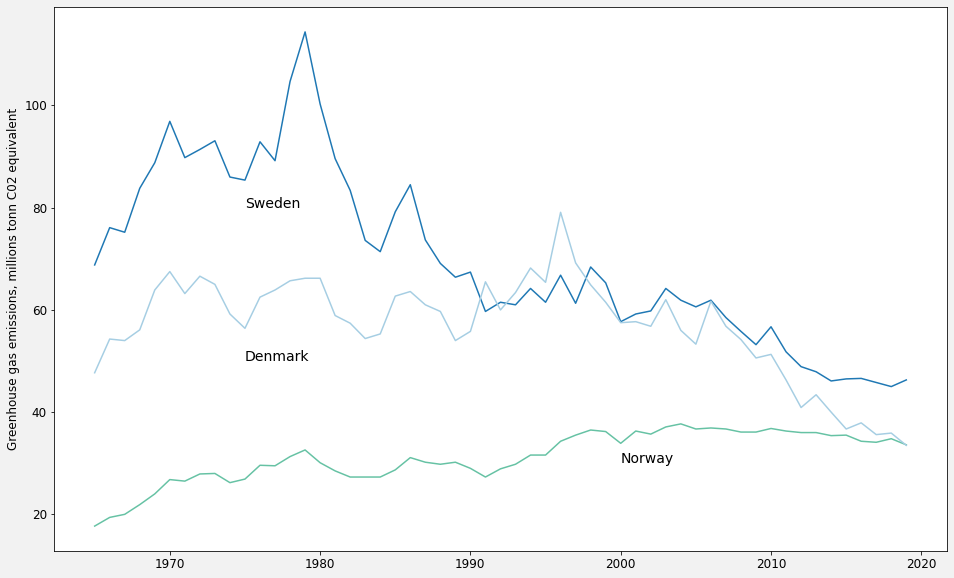

In [29]:
fig, ax = plt.subplots()
ax.plot(utslipp["year"], utslipp["Norway"])
ax.annotate("Norway", xy=(2000, 30))
ax.plot(utslipp["year"], utslipp["Sweden"])
ax.annotate("Sweden", xy=(1975, 80))
ax.plot(utslipp["year"], utslipp["Denmark"])
ax.annotate("Denmark", xy=(1975, 50))
#ax.plot(utslipp["year"], utslipp["European Union"])
#ax.annotate("Air and sea traffic, fishing", xy=(2010, 6000))
ax.set_ylabel("Greenhouse gas emissions, millions tonn C02 equivalent")
fig.savefig("figures/CO2_emissions.png")
plt.show()

In [9]:
#utslipp.columns.values

array(['4 Oppvarming i andre nµringer og husholdninger\t"Klimagasser i alt"\t2509\t2263\t2041\t2042\t2037\t2089\t2607\t2180\t1938\t2176\t1632\t1857\t2032\t2466\t2126\t1721\t1862\t1665\t1496\t1652\t1816\t1308\t1199\t1190\t997\t874\t1014\t1005'],
      dtype=object)

In [6]:
#utslipp.columns = ["index", "year", "total", "oil and gas", "industry", 
                   "energy generation", "heating", "traffic", "air, sea and fishing", "agriculture", "other"]
#del utslipp["index"]

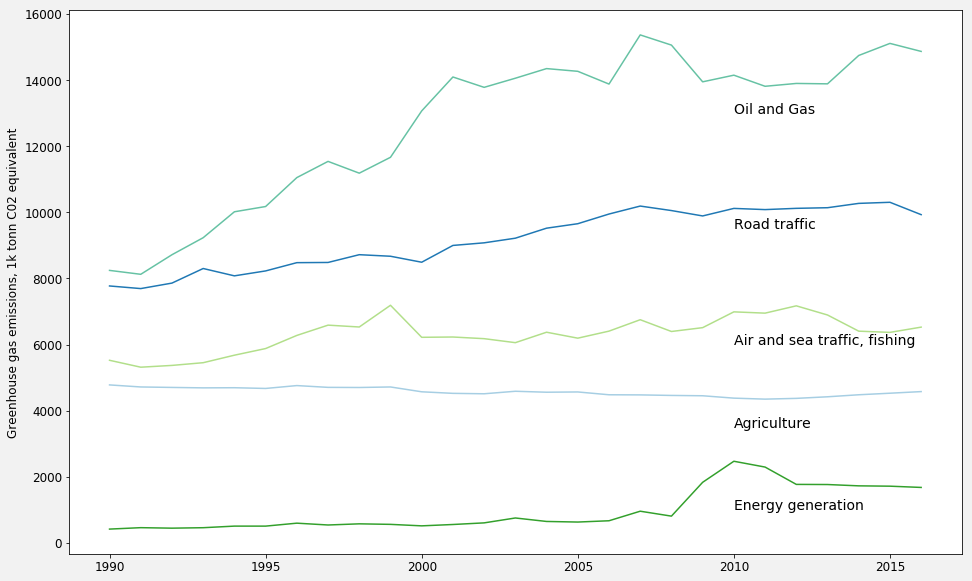

In [7]:
#fig, ax = plt.subplots()
#ax.plot(utslipp["year"], utslipp["oil and gas"])
#ax.annotate("Oil and Gas", xy=(2010, 13000))
#ax.plot(utslipp["year"], utslipp["traffic"])
#ax.annotate("Road traffic", xy=(2010, 9500))
#ax.plot(utslipp["year"], utslipp["agriculture"])
#ax.annotate("Agriculture", xy=(2010, 3500))
#ax.plot(utslipp["year"], utslipp["air, sea and fishing"])
#ax.annotate("Air and sea traffic, fishing", xy=(2010, 6000))
#ax.plot(utslipp["year"], utslipp["energy generation"])
#ax.annotate("Energy generation", xy=(2010, 1000))
#ax.set_ylabel("Greenhouse gas emissions, 1k tonn C02 equivalent")
#fig.savefig("figures/CO2_emissions.png")
#plt.show()

### EU ETS

In [30]:
ETS = pd.read_csv("https://www.quandl.com/api/v3/datasets/CHRIS/ICE_C3.csv?api_key=FerW555gC-wsJXPdTu8t")

In [31]:
ETS.loc[:,"Date"] = pd.to_datetime(ETS.Date)

In [32]:
ETS = ETS.sort_values("Date")

In [33]:
ETS

Date   Open   High    Low  Settle  Change   Wave  Volume  \
2609 2008-04-04  24.35  24.64  24.35   24.61   -0.18    NaN    45.0   
2608 2008-04-07  25.09  25.20  25.09   25.15    0.54    NaN    27.0   
2607 2008-04-08  25.25  25.25  24.85   24.87   -0.28    NaN    33.0   
2606 2008-04-09  25.05  25.05  25.04   25.05    0.18    NaN    20.0   
2605 2008-04-10  25.15  25.68  25.15   25.78    0.73    NaN    61.0   
...         ...    ...    ...    ...     ...     ...    ...     ...   
4    2020-07-16  29.14  29.39  26.70   26.72   -2.21  28.43  2388.0   
3    2020-07-17  26.96  27.53  26.96   27.92    1.20  27.19   528.0   
2    2020-07-20  27.60  27.60  26.12   26.26   -1.66  26.87    27.0   
1    2020-07-21  26.86  26.86  26.17   26.70    0.44  26.69    32.0   
0    2020-07-22  26.49  26.81  26.09   26.72    0.02  26.47    39.0   

      Prev. Day Open Interest  EFP Volume  EFS Volume  Block Volume  
2609                  17022.0       205.0         0.0           0.0  
2608                  16912.0        70.0         0.0           0.0  
2607                  16929.0       270.0         0.0           0.0  
2606                  16794.0         0.0         0.0           0.0  
2605                  16814.0       185.0         0.0           0.0  
...                       ...         ...         ...           ...  
4                     96856.0         NaN         NaN        1500.0  
3                     96219.0         NaN         NaN           NaN  
2                     96209.0         NaN         NaN           NaN  
1                     96209.0         NaN         NaN           NaN  
0                     96186.0         NaN         NaN           NaN  

[2610 rows x 12 columns]

In [34]:
ETS.to_csv("data_series/emissions_prices.csv", index=False)

In [42]:
#data on coal prices, among others
bp_coal = pd.read_csv("data/coalPrices.csv", sep=";", decimal=",")

In [43]:
bp_coal

US dollars per tonne  Northwest Europe marker price †  \
0                   1987                            31.30   
1                   1988                            39.94   
2                   1989                            42.08   
3                   1990                            43.48   
4                   1991                            42.80   
5                   1992                            38.53   
6                   1993                            33.68   
7                   1994                            37.18   
8                   1995                            44.50   
9                   1996                            41.25   
10                  1997                            38.92   
11                  1998                            32.00   
12                  1999                            28.79   
13                  2000                            35.99   
14                  2001                            39.03   
15                  2002                            31.65   
16                  2003                            43.60   
17                  2004                            72.13   
18                  2005                            60.54   
19                  2006                            64.11   
20                  2007                            88.79   
21                  2008                           147.67   
22                  2009                            70.39   
23                  2010                            92.35   
24                  2011                           121.48   
25                  2012                            92.50   
26                  2013                            81.69   
27                  2014                            75.38   
28                  2015                            56.79   
29                  2016                            59.87   
30                  2017                            84.51   
31                  2018                            91.83   
32                  2019                            60.86   

   US Central Appalachian coal spot price index ‡  \
0                                               -   
1                                               -   
2                                               -   
3                                           31,59   
4                                           29,01   
5                                           28,53   
6                                           29,85   
7                                           31,72   
8                                           27,01   
9                                           29,86   
10                                          29,76   
11                                          31,00   
12                                          31,29   
13                                          29,90   
14                                          50,15   
15                                          33,20   
16                                          38,52   
17                                          64,90   
18                                          70,12   
19                                          57,82   
20                                          49,73   
21                                         117,42   
22                                          60,73   
23                                          67,87   
24                                          84,75   
25                                          67,28   
26                                          69,72   
27                                          67,08   
28                                          51,57   
29                                          51,45   
30                                          63,83   
31                                          72,84   
32                                          57,16   

   Japan steam spot CIF price  † China Qinhuangdao spot price*  \
0                              -                            

In [44]:
bp_coal = bp_coal.iloc[1:, 0:8]
bp_coal.columns = ['year', 'Northwest Europe marker price',
       'US Central Appalachian coal spot price index',
       'Japan steam spot cif price', 'China Qinhuangdao spot price',
       'Japan coking coal import cif price',
       'Japan steam coal import cif price', 'Asian marker price']

bp_coal.tail()

year  Northwest Europe marker price  \
28  2015                          56.79   
29  2016                          59.87   
30  2017                          84.51   
31  2018                          91.83   
32  2019                          60.86   

   US Central Appalachian coal spot price index Japan steam spot cif price  \
28                                        51,57                      60,10   
29                                        51,45                      71,66   
30                                        63,83                      95,57   
31                                        72,84                     112,73   
32                                        57,16                      77,63   

   China Qinhuangdao spot price  Japan coking coal import cif price  \
28                        67,53                               93.85   
29                        71,35                               89.40   
30                        94,72                              150.00   
31                        99,45                              158.49   
32                        85,89                              148.52   

    Japan steam coal import cif price Asian marker price  
28                              79.47              63,52  
29                              72.97              71,12  
30                              99.16              99,42  
31                             117.39             111,69  
32                             108.58              80,81

In [47]:
bp_coal.head()

year  Northwest Europe marker price  \
1  1988                          39.94   
2  1989                          42.08   
3  1990                          43.48   
4  1991                          42.80   
5  1992                          38.53   

  US Central Appalachian coal spot price index Japan steam spot cif price  \
1                                            -                          -   
2                                            -                          -   
3                                        31,59                          -   
4                                        29,01                          -   
5                                        28,53                          -   

  China Qinhuangdao spot price  Japan coking coal import cif price  \
1                            -                               55.06   
2                            -                               58.68   
3                            -                               60.54   
4                            -                               60.45   
5                            -                               57.82   

   Japan steam coal import cif price Asian marker price  
1                              42.47                  -  
2                              48.86                  -  
3                              50.81                  -  
4                              50.30                  -  
5                              48.45                  -

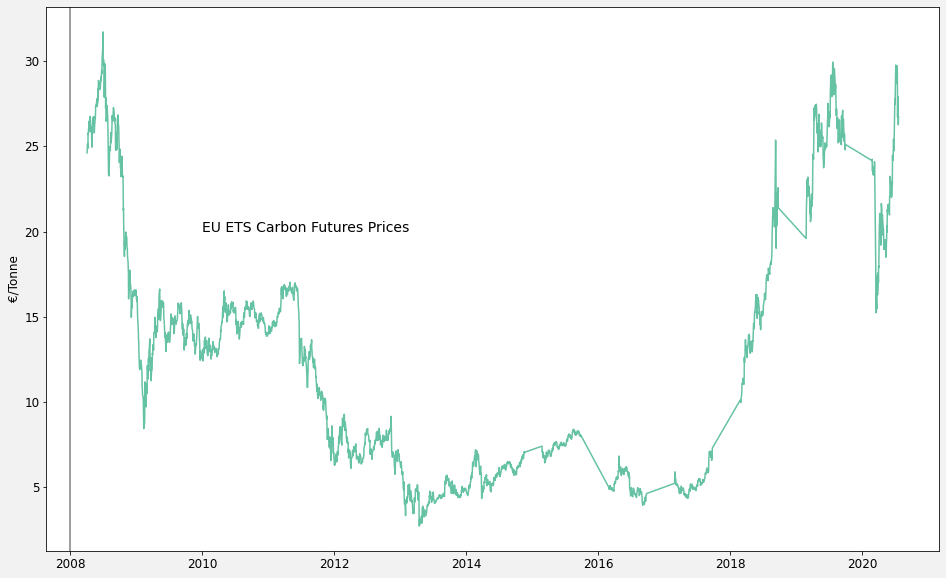

In [40]:
ETS.head()
fig, ax = plt.subplots()
ax.plot(ETS.Date, ETS.Settle)
ax.set_ylabel("€/Tonne")
ax.annotate("EU ETS Carbon Futures Prices", xy=(pd.to_datetime("2010-01-01"), 20))
ax.axvline(pd.to_datetime("2008-01-01"),color="grey")
fig.savefig("figures/carbon_prices.png")
plt.show()

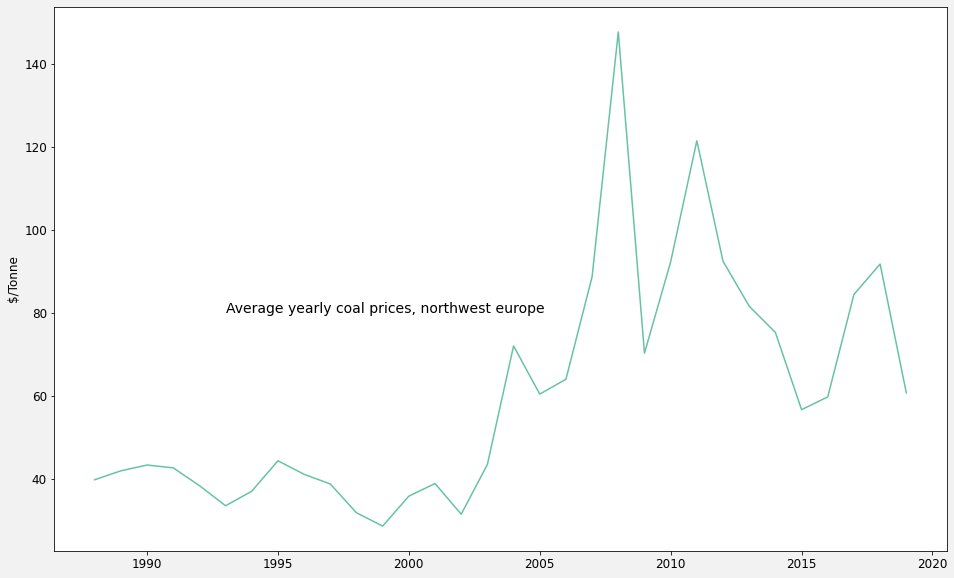

In [50]:
fig, ax = plt.subplots()
ax.plot(bp_coal.year, bp_coal["Northwest Europe marker price"])
ax.set_ylabel("$/Tonne")
ax.annotate("Average yearly coal prices, northwest europe", xy=(1993, 80))
plt.show()

### Electricity prices

Data from Nord Pool Spot

In [113]:
from urllib.request import urlopen
from bs4 import BeautifulSoup


In [114]:
years = [y for y in range(2000, 2020)]
years = [str(y) for y in years]
start = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/elspot-prices_"
end = "_monthly_eur.xls"
#end = "_daily_eur.xls" #daily
urls = []
for year in years:
    urls.append(start+year+end)


In [115]:
tables=[]
for t, url in enumerate(urls):
    tables.append(clean_elspot_data(url))

In [116]:
elspot = pd.concat(tables)

In [117]:
elspot.columns.values

array(['Unnamed: 0', 'SYS', 'SE', 'FI', 'DK1', 'DK2', 'Oslo', 'Kr.sand',
       'Bergen', 'Molde', 'Tr.heim', 'Troms\\xc3\\xb8', 'KT', 'EE', 'SE1',
       'SE2', 'SE3', 'SE4', 'ELE', 'LT', 'LV', 'AT', 'BE', 'DE-LU', 'FR',
       'NL'], dtype=object)

In [118]:
#daily
elspot.columns = ['date', 'SYS', 'SE', 'FI', 'DK1', 'DK2', 'Oslo', 'Kristiansand',
       'Bergen', 'Molde', 'Trondheim', 'Tromsoe', 'KT', 'EE', 'SE1',
       'SE2', 'SE3', 'SE4', 'ELE', 'LT', 'LV', 'AT', 'BE', 'DE-LU', 'FR',
       'NL']

In [119]:
elspot.tail()

date   SYS  SE    FI   DK1     DK2  Oslo  Kristiansand  Bergen  Molde  \
7   19 - Aug  3611 NaN  4877  3787  3949.0  3473          3473    3473   3663   
8   19 - Sep  3292 NaN  4875  3538  3732.0  2986          3004    2986   3333   
9   19 - Oct  3710 NaN  4633  3826  4150.0  3673          3670    3673   3660   
10  19 - Nov  4215 NaN  4571  4175  4270.0  4227          4221    4236   4129   
11  19 - Dec  3679 NaN  3842  3404  3535.0  3802          3791    3804   3562   

    ...     SE3     SE4  ELE      LT      LV      AT      BE   DE-LU      FR  \
7   ...  3701.0  3864.0  NaN  4937.0  4949.0  3771.0  3372.0  3685.0  3339.0   
8   ...  3474.0  3656.0  NaN  4879.0  4885.0  3804.0  3357.0  3575.0  3554.0   
9   ...  3771.0  4209.0  NaN  4696.0  4733.0  3898.0  3760.0  3694.0  3860.0   
10  ...  4180.0  4231.0  NaN  4470.0  4526.0  4274.0  4440.0  4100.0  4594.0   
11  ...  3601.0  3670.0  NaN  3897.0  3905.0  3811.0  3636.0  3197.0  3646.0   

        NL  
7   3744.0  
8   3657.0  
9   3794.0  
10  4271.0  
11  3739.0  

[5 rows x 26 columns]

In [120]:
elspot.loc[:, "date"] = pd.to_datetime(elspot["date"], format = "%y - %b")

In [121]:
elspot.tail()

date   SYS  SE    FI   DK1     DK2  Oslo  Kristiansand  Bergen  \
7  2019-08-01  3611 NaN  4877  3787  3949.0  3473          3473    3473   
8  2019-09-01  3292 NaN  4875  3538  3732.0  2986          3004    2986   
9  2019-10-01  3710 NaN  4633  3826  4150.0  3673          3670    3673   
10 2019-11-01  4215 NaN  4571  4175  4270.0  4227          4221    4236   
11 2019-12-01  3679 NaN  3842  3404  3535.0  3802          3791    3804   

    Molde  ...     SE3     SE4  ELE      LT      LV      AT      BE   DE-LU  \
7    3663  ...  3701.0  3864.0  NaN  4937.0  4949.0  3771.0  3372.0  3685.0   
8    3333  ...  3474.0  3656.0  NaN  4879.0  4885.0  3804.0  3357.0  3575.0   
9    3660  ...  3771.0  4209.0  NaN  4696.0  4733.0  3898.0  3760.0  3694.0   
10   4129  ...  4180.0  4231.0  NaN  4470.0  4526.0  4274.0  4440.0  4100.0   
11   3562  ...  3601.0  3670.0  NaN  3897.0  3905.0  3811.0  3636.0  3197.0   

        FR      NL  
7   3339.0  3744.0  
8   3554.0  3657.0  
9   3860.0  3794.0  
10  4594.0  4271.0  
11  3646.0  3739.0  

[5 rows x 26 columns]

In [122]:
elspot2020 = clean_elspot_data("https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/elspot-prices_2020_monthly_eur.xls")
elspot2020.columns.values

array(['Unnamed: 0', 'SYS', 'SE1', 'SE2', 'SE3', 'SE4', 'FI', 'DK1',
       'DK2', 'Oslo', 'Kr.sand', 'Bergen', 'Molde', 'Tr.heim',
       'Troms\\xc3\\xb8', 'EE', 'LV', 'LT', 'AT', 'BE', 'DE-LU', 'FR',
       'NL'], dtype=object)

In [123]:
elspot2020.columns = ['date', 'SYS', 'SE1', 'SE2', 'SE3', 'SE4', 'FI', 'DK1',
       'DK2', 'Oslo', 'Kristiansand', 'Bergen', 'Molde', 'Trondheim',
       'Tromsoe', 'EE', 'LV', 'LT', 'AT', 'BE', 'DE-LU', 'FR',
       'NL']

In [124]:
elspot2020.loc[:, "date"] = pd.to_datetime(elspot2020["date"], format = "%y - %b")

In [125]:
elspot = pd.concat([elspot, elspot2020])

#### Consumption

In [75]:
cons = clean_elspot_data("http://www.nordpoolspot.com/globalassets/marketdata-excel-files/consumption-per-country_2014_daily.xls")
cons.head()

Unnamed: 0      NO      SE      FI     DK    Nordic     EE     LV     LT  \
0  01-01-2014  366427  384749  222609  83837  10576380  19487  17885  22959   
1  02-01-2014  399918  411970  246089  99705  11576840  23373  21578  27295   
2  03-01-2014  394838  412474  252240  98515  11580790  24053  22123  27322   
3  04-01-2014  373405  390819  239997  89931  10941670  21959  20152  24993   
4  05-01-2014  369245  388306  229357  88121  10750310  21025  19587  24387   

   Baltic  
0  603310  
1  722460  
2  734980  
3  671040  
4  649990

In [76]:
cons=[]
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
for year in years:
    cons.append(clean_elspot_data("http://www.nordpoolspot.com/globalassets/marketdata-excel-files/consumption-per-country_"+year+"_daily.xls"))
consumption = pd.concat(cons)

In [77]:
consumption.columns.values

array(['Unnamed: 0', 'NO', 'SE', 'FI', 'DK', 'Nordic', 'EE', 'LV', 'LT',
       'Baltic'], dtype=object)

In [78]:
consumption.columns = ['date', 'NO', 'SE', 'FI', 'DK', 'Nordic', 'EE', 'LV', 'LT','Baltic']
consumption.loc[:, "date"] = pd.to_datetime(consumption.date, format="%d-%m-%Y")

In [79]:
#weird values for Norwegian data
consumption = consumption[consumption.NO > 100000]

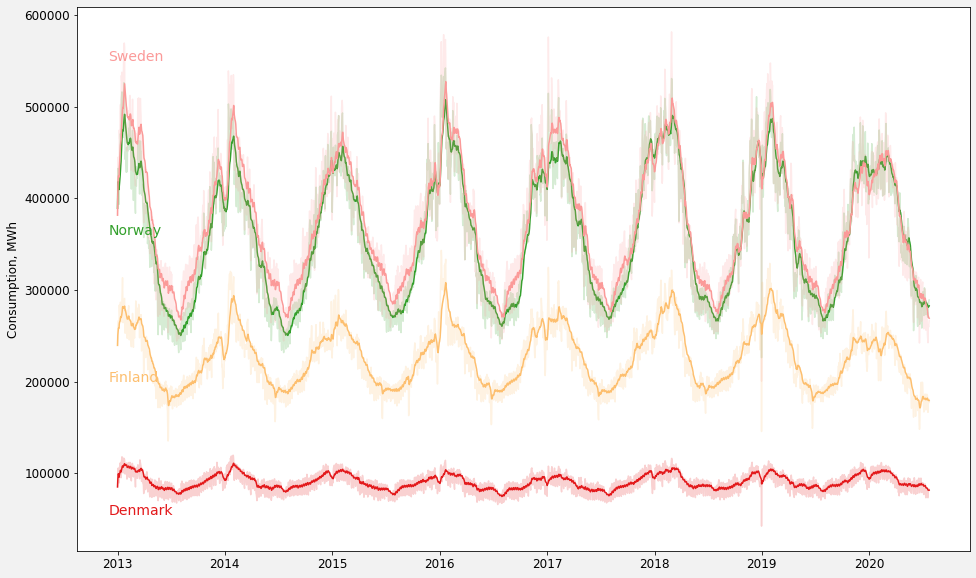

In [80]:
fig, ax = plt.subplots()
ax.plot(consumption["date"], consumption["NO"], alpha=.2, color='#33a02c')
ax.plot(consumption["date"], consumption["NO"].ewm(min_periods=0,ignore_na=True,adjust=True,span=20).mean(), color='#33a02c')
ax.annotate("Norway", xy=(pd.to_datetime("2012-12-01"), 360000), color='#33a02c')
ax.plot(consumption["date"], consumption["SE"], alpha=.2, color='#fb9a99')
ax.plot(consumption["date"], consumption["SE"].ewm(min_periods=0,ignore_na=True,adjust=True,span=20).mean(), color='#fb9a99')
ax.annotate("Sweden", xy=(pd.to_datetime("2012-12-01"), 550000), color='#fb9a99')
ax.plot(consumption["date"], consumption["DK"], alpha=.2, color='#e31a1c')
ax.plot(consumption["date"], consumption["DK"].ewm(min_periods=0,ignore_na=True,adjust=True,span=20).mean(), color='#e31a1c')
ax.annotate("Denmark", xy=(pd.to_datetime("2012-12-01"), 55000), color='#e31a1c')

ax.plot(consumption["date"], consumption["FI"], alpha=.2, color='#fdbf6f')
ax.plot(consumption["date"], consumption["FI"].ewm(min_periods=0,ignore_na=True,adjust=True,span=20).mean(), color='#fdbf6f')
ax.annotate("Finland", xy=(pd.to_datetime("2012-12-01"), 200000), color='#fdbf6f')
ax.set_ylabel("Consumption, MWh")
fig.savefig("figures/electricity_consumption.png")
plt.show()
#'#33a02c','#fb9a99','#e31a1c','#fdbf6f'

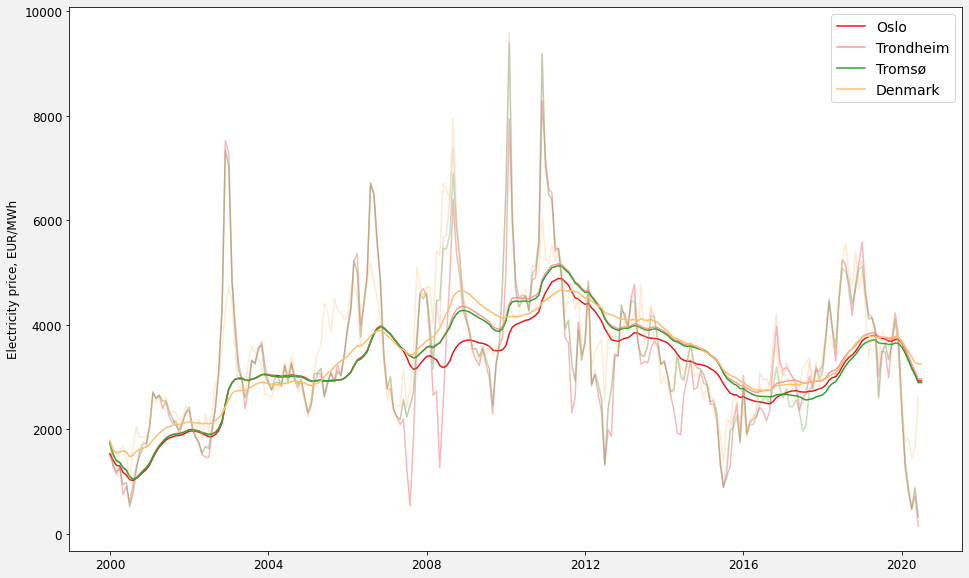

In [128]:
fig, ax = plt.subplots()
ax.plot(elspot["date"], elspot["Oslo"], color="#e31a1c", alpha=.3, label="")
ax.plot(elspot["date"], elspot["Oslo"].ewm(min_periods=0,ignore_na=False,adjust=True,span=36).mean(), color="#e31a1c", label="Oslo")
ax.plot(elspot["date"], elspot["Trondheim"], color='#fb9a99', alpha=.3, label="")
ax.plot(elspot["date"], elspot["Trondheim"].ewm(min_periods=0,ignore_na=False,adjust=True,span=36).mean(), color='#fb9a99', label="Trondheim")
ax.plot(elspot["date"], elspot["Tromsoe"], color='#33a02c', alpha=.3, label="")
ax.plot(elspot["date"], elspot["Tromsoe"].ewm(min_periods=0,ignore_na=False,adjust=True,span=36).mean(), color='#33a02c', label="Tromsø")
ax.plot(elspot["date"], elspot["DK1"], color='#fdbf6f', alpha=.3, label="")
ax.plot(elspot["date"], elspot["DK1"].ewm(min_periods=0,ignore_na=False,adjust=True,span=36).mean(), color='#fdbf6f', label="Denmark")


ax.set_ylabel("Electricity price, EUR/MWh")
ax.legend()
fig.savefig("figures/electricity_prices.png")
plt.show()
#'#33a02c','#fb9a99','#e31a1c','#fdbf6f'

In [34]:
elspot.head()

Bergen   DK1  DK2  EE  ELE    FI  FRE  KT  Kristiansand  LT  ...  Oslo  \
0    1528  1779  NaN NaN  NaN  1869  NaN NaN          1528 NaN  ...  1528   
1    1287  1431  NaN NaN  NaN  1292  NaN NaN          1287 NaN  ...  1287   
2    1134  1453  NaN NaN  NaN  1249  NaN NaN          1134 NaN  ...  1134   
3    1265  1593  NaN NaN  NaN  1301  NaN NaN          1265 NaN  ...  1265   
4     745  1680  NaN NaN  NaN  1431  NaN NaN           745 NaN  ...   745   

       SE  SE1  SE2  SE3  SE4   SYS  Trondheim  Tromsoe       date  
0  1869.0  NaN  NaN  NaN  NaN  1622       1741     1741 2000-01-01  
1  1292.0  NaN  NaN  NaN  NaN  1289       1291     1291 2000-02-01  
2  1232.0  NaN  NaN  NaN  NaN  1178       1191     1191 2000-03-01  
3  1300.0  NaN  NaN  NaN  NaN  1280       1273     1273 2000-04-01  
4  1426.0  NaN  NaN  NaN  NaN   951        937      937 2000-05-01  

[5 rows x 22 columns]

In [35]:
elspot.to_csv("data_series/elspot.csv", index=False)



#### Wind Power

In [249]:
years = [str(y) for y in range(2013, 2020)]
urls = ["http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-per-country_"+year+"_daily.xls" for year in years]

In [250]:
wds = []
for url in urls:
    wds.append(clean_elspot_data(url))
wind_data = pd.concat(wds) 

In [251]:
wind_data.columns.values

array(['Unnamed: 0', 'DK1', 'DK2', 'EE', 'LV', 'LT', 'SE1', 'SE2', 'SE3',
       'SE4', 'FI'], dtype=object)

In [252]:
wind_data.columns = ['date', 'DK1', 'DK2', 'EE', 'LV', 'LT', 'SE1', 'SE2', 'SE3',
       'SE4', 'FI']

In [253]:
wind_data2020 = clean_elspot_data("http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-per-country_2020_daily.xls")

In [254]:
wind_data2020.columns = ['date', 'SE1', 'SE2', 'SE3', 'SE4', 'FI', 'DK1', 'DK2', 'EE',
       'LV', 'LT']

In [255]:
wind_data = pd.concat([wind_data, wind_data2020])

In [256]:
wind_data.loc[:, "date"] = pd.to_datetime(wind_data["date"], format="%d-%m-%Y")

In [257]:
wind_data["DK"] = wind_data["DK1"] + wind_data["DK2"]

In [258]:
wind_data["SE"] = wind_data["SE1"] + wind_data["SE2"] + wind_data["SE3"] + wind_data["SE4"]

In [259]:
wind_data.to_csv("data_series/dk_se_wind_data.csv", index=False)

In [260]:
wind_data.tail()

date    DK1    DK2    EE     LV    LT     SE1      SE2      SE3  \
202 2020-07-21  45041   9174  1393  327.0  6063  1914.0  25704.0  10366.0   
203 2020-07-22  36184   5493  3246  371.0  6792     NaN      NaN      NaN   
204 2020-07-23  19814   2317  2732  426.0  4793     NaN      NaN      NaN   
205 2020-07-24  34705  11927  2370  443.0  3282     NaN      NaN      NaN   
206 2020-07-25   1726    783   182   42.0   287     NaN      NaN      NaN   

        SE4      FI     DK       SE  
202  9316.0  2543.0  54215  47300.0  
203     NaN     NaN  41677      NaN  
204     NaN     NaN  22131      NaN  
205     NaN     NaN  46632      NaN  
206     NaN     NaN   2509      NaN

##### Norwegian data

In [261]:
n_wind = pd.read_csv("data/NorgeVind.csv", sep=";")

In [262]:
n_wind.columns=["date", "NO"]

In [263]:
n_wind.loc[:,"date"] = pd.to_datetime(n_wind.date, format="%d.%m.%y")


In [264]:
wind_data = wind_data.merge(n_wind, how="left", on="date")
wind_data.tail()

date    DK1    DK2    EE     LV    LT     SE1      SE2      SE3  \
2758 2020-07-21  45041   9174  1393  327.0  6063  1914.0  25704.0  10366.0   
2759 2020-07-22  36184   5493  3246  371.0  6792     NaN      NaN      NaN   
2760 2020-07-23  19814   2317  2732  426.0  4793     NaN      NaN      NaN   
2761 2020-07-24  34705  11927  2370  443.0  3282     NaN      NaN      NaN   
2762 2020-07-25   1726    783   182   42.0   287     NaN      NaN      NaN   

         SE4      FI     DK       SE  NO  
2758  9316.0  2543.0  54215  47300.0 NaN  
2759     NaN     NaN  41677      NaN NaN  
2760     NaN     NaN  22131      NaN NaN  
2761     NaN     NaN  46632      NaN NaN  
2762     NaN     NaN   2509      NaN NaN

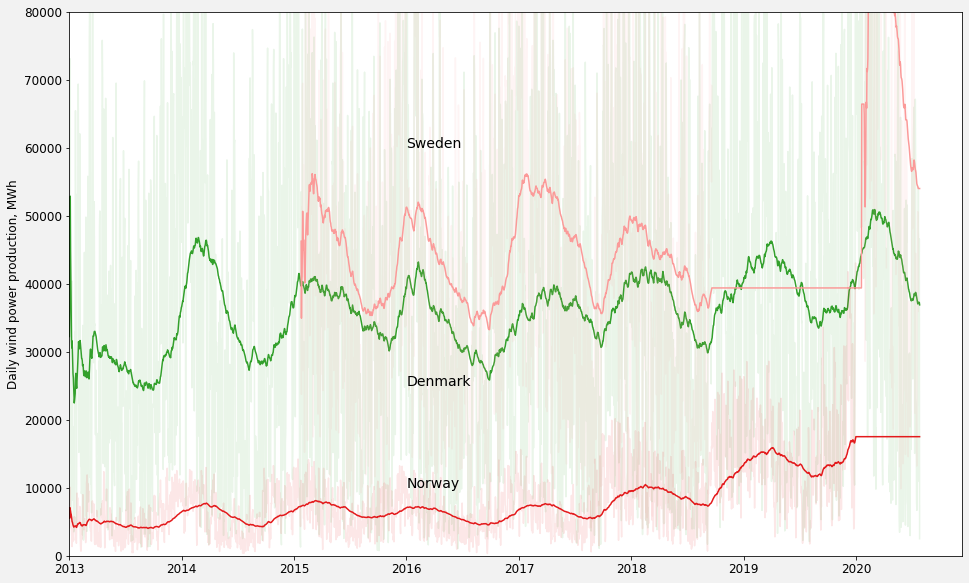

In [265]:
text_date = pd.to_datetime("2016-01-01")
fig, ax = plt.subplots()
ax.plot(wind_data["date"], wind_data["DK"], alpha=.1, color='#33a02c', label="Denmark")
ax.plot(wind_data["date"], wind_data["DK"].ewm(min_periods=0,ignore_na=False,adjust=True,span=200).mean(), color='#33a02c', label="")
ax.plot(wind_data["date"], wind_data["SE"], alpha=.1, color ='#fb9a99' , label="Sweden")
ax.plot(wind_data["date"], wind_data["SE"].ewm(min_periods=0,ignore_na=False,adjust=True,span=200).mean(), color= '#fb9a99', label="")
ax.plot(wind_data["date"], wind_data["NO"], alpha=.1, color='#e31a1c')
ax.plot(wind_data["date"], wind_data["NO"].ewm(min_periods=0,ignore_na=False,adjust=True,span=200).mean(), color='#e31a1c')

ax.annotate("Sweden", xy=(text_date, 60000))
ax.annotate("Denmark", xy=(text_date, 25000))
ax.annotate("Norway", xy=(text_date, 10000))
ax.set_ylim(0, 80000)
ax.set_xlim(pd.to_datetime("2013-01-01"))
ax.set_ylabel("Daily wind power production, MWh")
fig.savefig("figures/nordic_wind.png")
plt.show()
#'#33a02c','#fb9a99','#e31a1c','#fdbf6f'

#### Exchange

In [266]:
url = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/exchange-per-country_2017_daily.xls"
test = clean_elspot_data(url)
test.head()

Unnamed: 0  NO net exchange  SE net exchange  FI net exchange  \
0  01-01-2017             1725           -42336            64029   
1  02-01-2017           -64215           -32522            74298   
2  03-01-2017           -44158            -5691            79574   
3  04-01-2017           -13396           -19650            86677   
4  05-01-2017           -71402             8162           102338   

   DK net exchange  EE net exchange  LV net exchange  LT net exchange  
0            -5238             -467             1957            13750  
1            18293            -2481            -6582            23041  
2           -15661             2159            -6727            25376  
3           -27355           -10729            -6301            23769  
4             -527           -10803           -13782            20887

In [267]:
years = ["2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
exs = []
for year in years:
    url = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/exchange-per-country_" + year +"_daily.xls"
    exs.append(clean_elspot_data(url))
exchange = pd.concat(exs)    

In [268]:
exchange.columns = ['date', 'NO net exchange', 'SE net exchange',
       'FI net exchange', 'DK net exchange', 'EE net exchange',
       'LV net exchange', 'LT net exchange']

In [269]:
exchange.loc[:, "date"] = pd.to_datetime(exchange["date"], format="%d-%m-%Y")

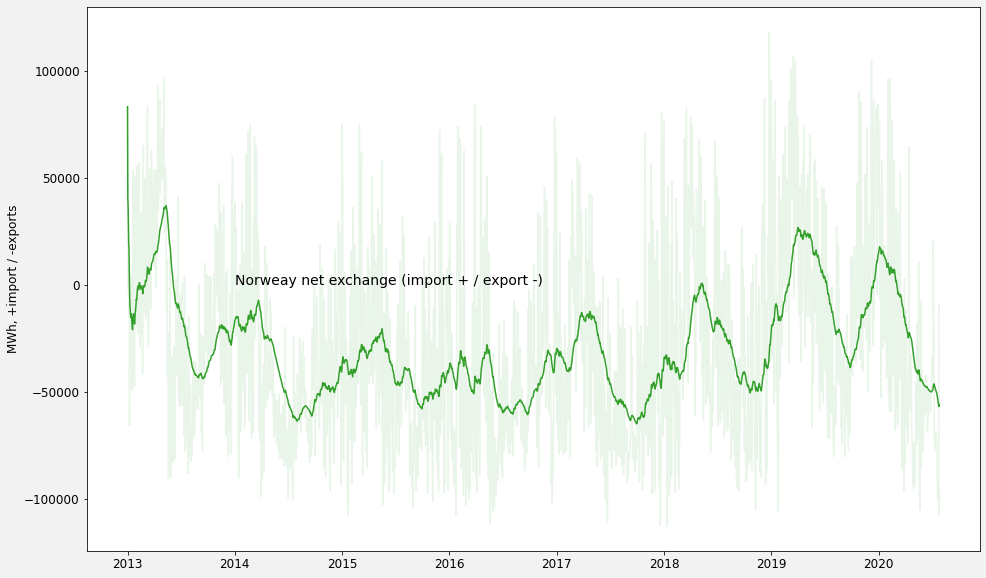

In [270]:
#import+  #export-
fig, ax = plt.subplots()
ax.plot(exchange["date"], exchange["NO net exchange"], alpha=.1, color='#33a02c')
ax.plot(exchange["date"], exchange["NO net exchange"].ewm(min_periods=0,ignore_na=False,adjust=True,span=100).mean(),color='#33a02c')
ax.set_ylabel("MWh, +import / -exports")
ax.annotate("Norweay net exchange (import + / export -)", xy=(pd.to_datetime("2014-01-01"), 0))
fig.savefig("figures/net_exchange.png")
plt.show()

### Business Tendency survey

In [271]:
BTS = pd.read_csv("http://data.ssb.no/api/v0/dataset/166316.csv", sep=";", decimal=".", na_values = [".", ".."], encoding="iso8859_10")

In [272]:
BTS.tail()
BTS.columns = ["industry", "adjustment", "time", "variabel", "bus_index"]

In [273]:
BTS.industry.unique()
BTS.adjustment.unique()
BTS.variabel.unique()

array(['Sammensatt konjunkturindikator',
       'Kapasitetsutnyttingsgraden, veid gjennomsnitt',
       'Antall arbeidsmåneder dekket ved ordrebeholdningen, veid gjennomsnitt',
       'Indikator på ressursknapphet'], dtype=object)

In [274]:
BTS_SA = BTS[BTS.industry=='P103 Industri og bergverksdrift']
BTS_SA = BTS_SA[BTS_SA.adjustment=='S Sesongjustert']
BTS_SA = BTS_SA[BTS_SA.variabel =='Sammensatt konjunkturindikator']

In [275]:
BTS_SA.head()

industry       adjustment    time  \
488  P103 Industri og bergverksdrift  S Sesongjustert  1990K1   
492  P103 Industri og bergverksdrift  S Sesongjustert  1990K2   
496  P103 Industri og bergverksdrift  S Sesongjustert  1990K3   
500  P103 Industri og bergverksdrift  S Sesongjustert  1990K4   
504  P103 Industri og bergverksdrift  S Sesongjustert  1991K1   

                           variabel bus_index  
488  Sammensatt konjunkturindikator       2,9  
492  Sammensatt konjunkturindikator       5,2  
496  Sammensatt konjunkturindikator      -4,5  
500  Sammensatt konjunkturindikator       2,6  
504  Sammensatt konjunkturindikator      -4,3

In [276]:
def quarterly_to_monthly(string):
    year, quarter = string.split("K")
    month = pd.to_numeric(quarter)*3
    return(year + "-" + str(month) + "-1")

quarterly_to_monthly("1990K1")

'1990-3-1'

In [277]:
BTS_SA.loc[:,"time"] = BTS_SA.time.apply(quarterly_to_monthly)

In [278]:
BTS_SA.loc[:, "time"] = pd.to_datetime(BTS_SA.time, format="%Y-%m-%d")

In [279]:
BTS_SA.head()

industry       adjustment       time  \
488  P103 Industri og bergverksdrift  S Sesongjustert 1990-03-01   
492  P103 Industri og bergverksdrift  S Sesongjustert 1990-06-01   
496  P103 Industri og bergverksdrift  S Sesongjustert 1990-09-01   
500  P103 Industri og bergverksdrift  S Sesongjustert 1990-12-01   
504  P103 Industri og bergverksdrift  S Sesongjustert 1991-03-01   

                           variabel bus_index  
488  Sammensatt konjunkturindikator       2,9  
492  Sammensatt konjunkturindikator       5,2  
496  Sammensatt konjunkturindikator      -4,5  
500  Sammensatt konjunkturindikator       2,6  
504  Sammensatt konjunkturindikator      -4,3

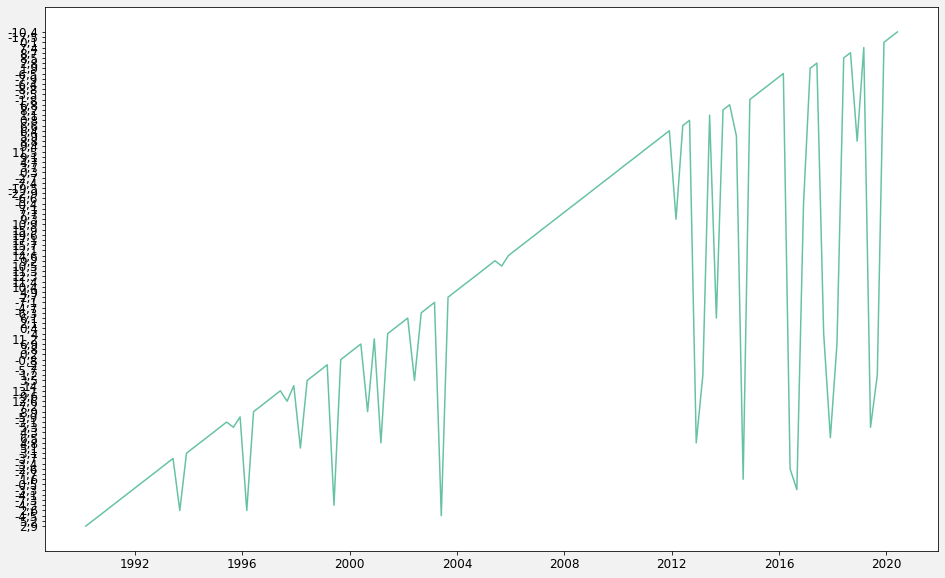

In [280]:
fig, ax = plt.subplots()
ax.plot(BTS_SA.time, BTS_SA.bus_index)
plt.show()


### Industrial production

In [281]:
IP = pd.read_csv("http://data.ssb.no/api/v0/dataset/27002.csv?lang=no", sep=",", decimal=".", na_values = [".", ".."], encoding="iso8859_10")
IP.head()

næring/varetype;"statistikkvariabel";"måned";"07095: Produksjonsindeks for industrien (2005=100)  \
0  P101 Utvinning, bergverk, industri og kraft;"P...                                                 
1  P101 Utvinning, bergverk, industri og kraft;"P...                                                 
2  P101 Utvinning, bergverk, industri og kraft;"P...                                                 
3  P101 Utvinning, bergverk, industri og kraft;"P...                                                 
4  P101 Utvinning, bergverk, industri og kraft;"P...                                                 

   etter næring/varetype   statistikkvariabel og måned"  
0                      7                            NaN  
1                      3                            NaN  
2                    NaN                            NaN  
3                      2                            NaN  
4                      2                            NaN

### Retail Sales

In [282]:
sales = pd.read_csv("http://data.ssb.no/api/v0/dataset/1066.csv?lang=no", sep=";", decimal=",", na_values = [".", ".."], encoding="iso8859_10")

In [283]:
sales.loc[:, "måned"] = sales.måned.apply(lambda x:  x.replace("M", ""))
sales.loc[:, "måned"] = pd.to_datetime(sales["måned"], format="%Y%m")

In [284]:
sales

næring      måned  \
0   47 Detaljhandel, unntatt salg av motorvogner 2019-05-01   
1   47 Detaljhandel, unntatt salg av motorvogner 2019-06-01   
2   47 Detaljhandel, unntatt salg av motorvogner 2019-07-01   
3   47 Detaljhandel, unntatt salg av motorvogner 2019-08-01   
4   47 Detaljhandel, unntatt salg av motorvogner 2019-09-01   
5   47 Detaljhandel, unntatt salg av motorvogner 2019-10-01   
6   47 Detaljhandel, unntatt salg av motorvogner 2019-11-01   
7   47 Detaljhandel, unntatt salg av motorvogner 2019-12-01   
8   47 Detaljhandel, unntatt salg av motorvogner 2020-01-01   
9   47 Detaljhandel, unntatt salg av motorvogner 2020-02-01   
10  47 Detaljhandel, unntatt salg av motorvogner 2020-03-01   
11  47 Detaljhandel, unntatt salg av motorvogner 2020-04-01   
12  47 Detaljhandel, unntatt salg av motorvogner 2020-05-01   

           statistikkvariabel  \
0   Volumindeks sesongjustert   
1   Volumindeks sesongjustert   
2   Volumindeks sesongjustert   
3   Volumindeks sesongjustert   
4   Volumindeks sesongjustert   
5   Volumindeks sesongjustert   
6   Volumindeks sesongjustert   
7   Volumindeks sesongjustert   
8   Volumindeks sesongjustert   
9   Volumindeks sesongjustert   
10  Volumindeks sesongjustert   
11  Volumindeks sesongjustert   
12  Volumindeks sesongjustert   

    07129: Detaljomsetningsindeksen, etter næring, måned og statistikkvariabel  
0                                               102.9                           
1                                               102.4                           
2                                               103.2                           
3                                               103.2                           
4                                               103.3                           
5                                               102.4                           
6                                               103.5                           
7                                               101.1                           
8                                               101.7                           
9                                               103.6                           
10                                              102.5                           
11                                              107.4                           
12                                              110.4

In [285]:
sales = sales[["måned", "07129: Detaljomsetningsindeksen, etter næring, måned og statistikkvariabel"]]

In [286]:
sales.columns = ["dato", "detaljomsetningsindeks"]

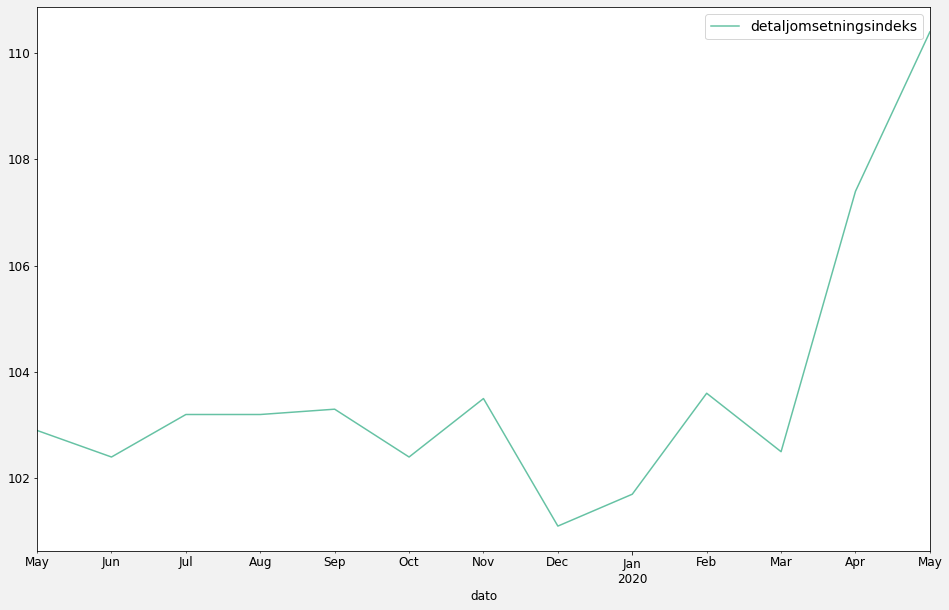

In [287]:
sales.plot(x="dato", y="detaljomsetningsindeks")

### Job Vacancies

### Import and Export

In [288]:
ih = pd.read_csv("http://data.ssb.no/api/v0/dataset/58962.csv?lang=en", 
	sep=",", decimal=".", na_values = [".", ".."])


In [289]:
ih.head()

trade flow    month contents  \
0  Itot Total imports  1980M01    Value   
1  Itot Total imports  1980M02    Value   
2  Itot Total imports  1980M03    Value   
3  Itot Total imports  1980M04    Value   
4  Itot Total imports  1980M05    Value   

  08792: External trade in goods, main figures (NOK million), by trade flow, month and contents  
0                                               6937                                             
1                                               6750                                             
2                                               7332                                             
3                                               6364                                             
4                                               6840

In [290]:

ih.columns = ["flow", "date", "variable", "value"]
ih.date = convert_datetime(ih.date)
ih.flow.unique()

array(['Itot Total imports', 'Itotuskip Imports excl. ships',
       'Itotuso Imports excl. ships and oil platforms',
       'Itotusor Imports excl. ships, oil platforms and crude oil',
       'Etot Total exports', 'Etotueski Exports excl. elderly ships',
       'Etotuskip Exports excl. ships',
       'Etotuso Exports excl. ships and oil platforms',
       'Etotusorn Mainland exports',
       'Hbtot Trade balance, goods (Total exports - total imports)',
       'Hbtotuso Trade balance, goods (Exports - imports, both excl. ships and oil platforms)',
       'Hbtusorn Trade balance, goods (Mainland exports - imports excl. ships and oil platforms)',
       'Iskip Imports of ships', 'Iskipeld Imports of elderly ships',
       'Iskipnye Imports of new ships', 'Iplat Imports of oil platforms',
       'Iskipplat Imports of ships and oil platforms',
       'Eolje Exports of crude oil', 'Egass Exports of natural gas',
       'Ekondens Exports of condensates',
       'Eoljegass Exports of crude oi

In [291]:
include = ['Etotusorn Mainland exports', 'Eoljegass Exports of crude oil, natural gas and condensates']
eksport  = ih[ih.flow.isin(include)]
eksport["value"] = eksport.value.astype(float)
eksport_w = eksport.pivot(index='date', columns='flow', values='value')
eksport_w.reset_index(inplace=True)

eksport_w.columns = ["date", "petroleum_export", "non_petroleum_export"]


In [292]:
eksport_w["perc_petroleum_export"] = eksport_w.petroleum_export.pct_change(periods=12)
eksport_w["smooth_petroleum_export"] = eksport_w.petroleum_export.rolling(window=12).mean()
eksport_w["perc_non_petroleum_export"] = eksport_w.non_petroleum_export.pct_change(periods=12)
eksport_w["smooth_non_petroleum_export"] = eksport_w.non_petroleum_export.rolling( window=12).mean()


In [293]:
eksport_w.to_csv("data_series/export.csv")

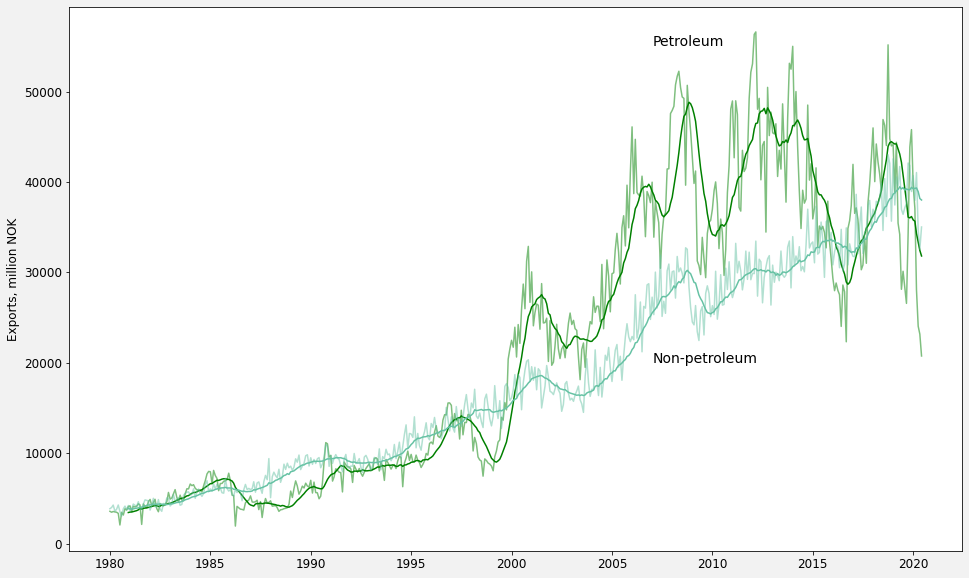

In [294]:
start = datetime.strptime('01012007', '%d%m%Y')

fig, ax = plt.subplots()
ax.plot()
ax.plot(eksport_w.date, eksport_w.petroleum_export, color="green", alpha=.5)
ax.plot(eksport_w.date, eksport_w.smooth_petroleum_export, color="green")
ax.plot(eksport_w.date, eksport_w.non_petroleum_export, color='#66c2a4', alpha=.5)
ax.plot(eksport_w.date, eksport_w.smooth_non_petroleum_export, color='#66c2a4')
ax.annotate('Petroleum', xy=(start, 55000))
ax.annotate('Non-petroleum', xy=(start, 20000))
ax.set_ylabel("Exports, million NOK")
fig.savefig("figures/exports_levels.png")
plt.show()

#### YoY pct change

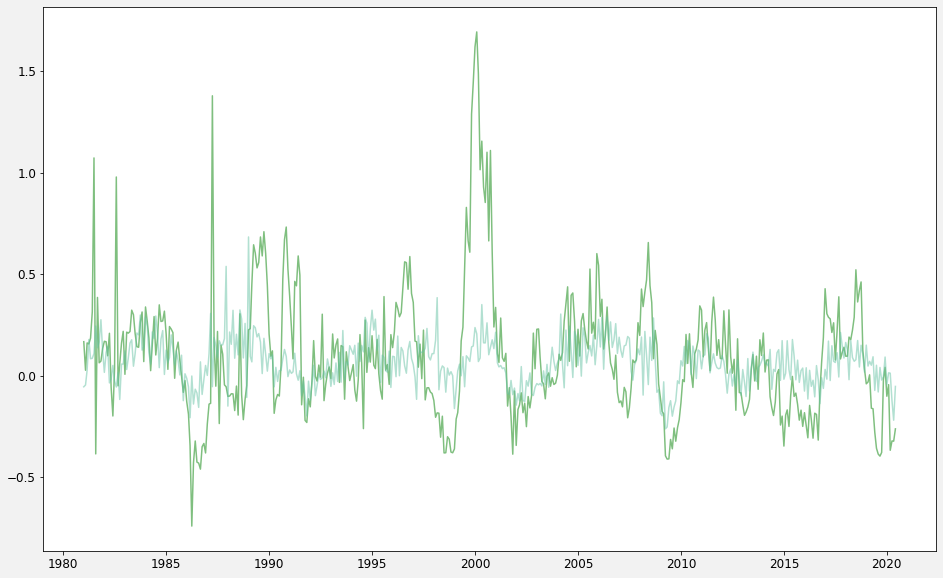

In [295]:
fig, ax = plt.subplots()
ax.plot()
ax.plot(eksport_w.date, eksport_w.perc_petroleum_export, color="green", alpha=.5)
#ax.plot(eksport_w.date, eksport_w.smooth_petroleum_export, color="green")
ax.plot(eksport_w.date, eksport_w.perc_non_petroleum_export, color='#66c2a4', alpha=.5)
#ax.plot(eksport_w.date, eksport_w.smooth_non_petroleum_export, color='#66c2a4')
#ax.annotate('Petroleum', xy=(start, 55000))
#ax.annotate('Non-petroleum', xy=(start, 20000))
#ax.set_ylabel("Exports, million NOK")
#fig.savefig("figures/exports_perc.png", bbox_inches='tight')
plt.show()

#### Trade balance

In [302]:
ih.flow.unique()

array(['Itot Total imports', 'Itotuskip Imports excl. ships',
       'Itotuso Imports excl. ships and oil platforms',
       'Itotusor Imports excl. ships, oil platforms and crude oil',
       'Etot Total exports', 'Etotueski Exports excl. elderly ships',
       'Etotuskip Exports excl. ships',
       'Etotuso Exports excl. ships and oil platforms',
       'Etotusorn Mainland exports',
       'Hbtot Trade balance, goods (Total exports - total imports)',
       'Hbtotuso Trade balance, goods (Exports - imports, both excl. ships and oil platforms)',
       'Hbtusorn Trade balance, goods (Mainland exports - imports excl. ships and oil platforms)',
       'Iskip Imports of ships', 'Iskipeld Imports of elderly ships',
       'Iskipnye Imports of new ships', 'Iplat Imports of oil platforms',
       'Iskipplat Imports of ships and oil platforms',
       'Eolje Exports of crude oil', 'Egass Exports of natural gas',
       'Ekondens Exports of condensates',
       'Eoljegass Exports of crude oi

In [303]:
include = ['Hbtot Trade balance, goods (Total exports - total imports)', "Hbtusorn Trade balance, goods (Mainland exports - imports excl. ships and oil platforms)"]
bal  = ih[ih.flow.isin(include)]


In [304]:
bal.head()

flow       date variable  \
4374  Hbtot Trade balance, goods (Total exports - to... 1980-01-01    Value   
4375  Hbtot Trade balance, goods (Total exports - to... 1980-02-01    Value   
4376  Hbtot Trade balance, goods (Total exports - to... 1980-03-01    Value   
4377  Hbtot Trade balance, goods (Total exports - to... 1980-04-01    Value   
4378  Hbtot Trade balance, goods (Total exports - to... 1980-05-01    Value   

     value  
4374  1187  
4375   922  
4376   672  
4377  1213  
4378   583

In [305]:
bal["value"] = bal.value.astype(float)

In [306]:

bal_w = bal.pivot(index='date', columns='flow', values='value')
bal_w.reset_index(inplace=True)
bal_w.columns = ["date", "trade_bal", "trade_bal_ex_pet"]



In [307]:
bal_w.head()
bal_w.to_csv("data_series/trade_balance.csv")

In [308]:
bal_w["smooth_bal"] = bal_w.trade_bal.rolling(window=12).mean()
bal_w["smooth_bal_ex_pet"] = bal_w.trade_bal_ex_pet.rolling(window=12).mean()


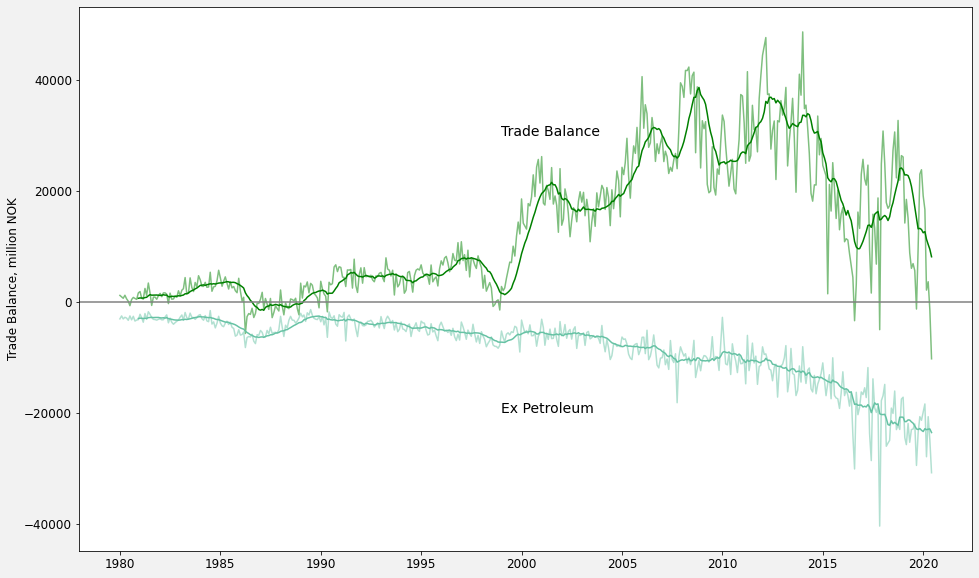

In [309]:
start = datetime.strptime('01011999', '%d%m%Y')

fig, ax = plt.subplots()
ax.plot(bal_w.date, bal_w.trade_bal, color="green", alpha=.5)
ax.plot(bal_w.date, bal_w.smooth_bal, color="green")
ax.plot(bal_w.date, bal_w.trade_bal_ex_pet, color="#66c2a4", alpha=.5)
ax.plot(bal_w.date, bal_w.smooth_bal_ex_pet, color="#66c2a4")
ax.annotate('Trade Balance', xy=(start, 30000))
ax.annotate('Ex Petroleum', xy=(start, -20000))
ax.set_ylabel("Trade Balance, million NOK")
plt.axhline(y=0.0, color='grey', linestyle='-')
fig.savefig("figures/trade_bal.png")
plt.show()

# Employment

In [310]:

employment_json = pd.read_json("https://data.ssb.no/api/v0/dataset/1054.json?lang=en")

age_labels = employment_json["dataset"]["dimension"]["Alder"]
sex_labels = employment_json["dataset"]["dimension"]["Kjonn"]
content_labels = employment_json["dataset"]["dimension"]["ContentsCode"]


In [311]:
employment = pd.read_csv("https://data.ssb.no/api/v0/dataset/1054.csv?lang=en")

employment.columns = ["sex", "age", "contents", "time", "value"]

unemp_1000 = employment[employment.contents == 'Unemployment (LFS) (1 000 persons), seasonally adjusted']
#unemp_1000 = unemp_1000[unemp_1000.sex=="0 Both sexes"]
unemp_1000 = unemp_1000[unemp_1000.age=="25-74 25-74 years"]
unemp_1000 = unemp_1000[["time", "sex", "value"]]

unemp_1000["time"] = unemp_1000.time.apply(lambda x:  x.replace("M", ""))
unemp_1000["time"] = pd.to_datetime(unemp_1000["time"], format="%Y%m")

unemp_1000["value"][unemp_1000.value == ".."] = np.nan
unemp_1000["value"] = unemp_1000.value.astype(float)

unemp_1000.columns =["date", "sex", "value"]
unemp_1000["sex"] = unemp_1000.sex.apply(lambda x: x[2:])


In [312]:
unemp_1000.head()
unemp_1000.to_csv("data_series/unemployed.csv")

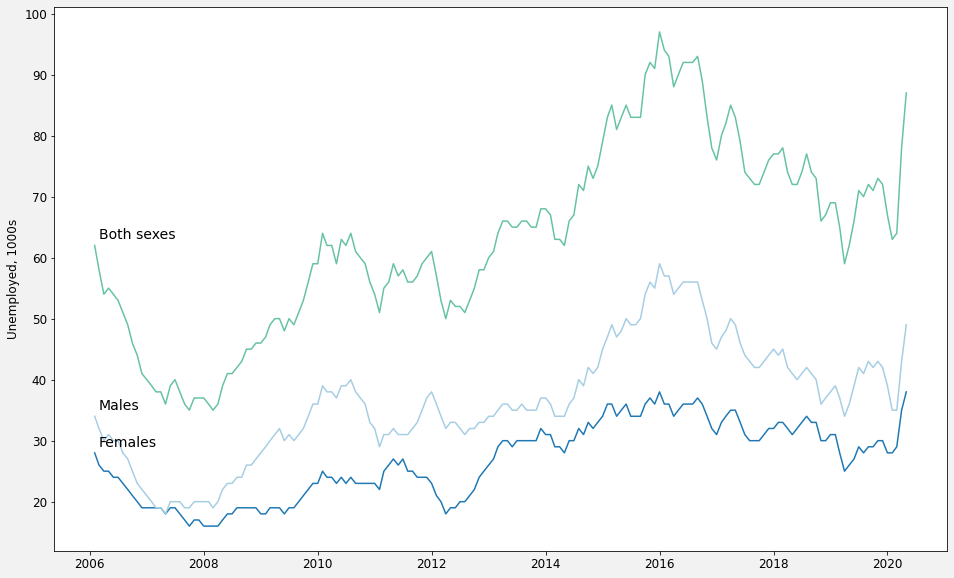

In [313]:
fig, ax = plt.subplots()
start = datetime.strptime('01032006', '%d%m%Y')
unemp_by_sex = unemp_1000.groupby("sex")
for unemp in unemp_by_sex:
	ax.plot(unemp[1].date, unemp[1].value, label=unemp[0])
	ax.annotate(unemp[0], xy=(start, np.array(unemp[1].value)[0]+1))
ax.set_ylabel("Unemployed, 1000s")
#ax.set_xlim(datetime.strptime('01012016', '%d%m%Y'))
fig.savefig("figures/unemployment.png")
plt.show()

In [314]:
emp_perc_sa = employment[employment.contents == "Employed persons in per cent of the population, seasonally adjusted"].copy()
emp_perc_sa.is_copy = False

emp_perc_sa = emp_perc_sa[emp_perc_sa.age=="25-74 25-74 years"]
emp_perc_sa = emp_perc_sa[["time", "sex", "value"]]

emp_perc_sa.loc[:,"time"] = emp_perc_sa.time.apply(lambda x:  x.replace("M", ""))
emp_perc_sa.loc[:,"time"] = pd.to_datetime(emp_perc_sa["time"], format="%Y%m")

emp_perc_sa.loc[:,"value"][emp_perc_sa.value == ".."] =np.nan
emp_perc_sa.loc[:,"value"] = emp_perc_sa.value.astype(float)

emp_perc_sa.columns =["date", "sex", "value"]
emp_perc_sa.loc[:,"sex"] = emp_perc_sa.sex.apply(lambda x: x[2:])

emp_perc_sa.set_index("date", inplace=True)
emp_perc_sa.reset_index(inplace=True)

start = datetime.strptime('01012008', '%d%m%Y')



In [315]:
emp_perc_sa.head()
emp_perc_sa.to_csv("data_series/employment.csv")

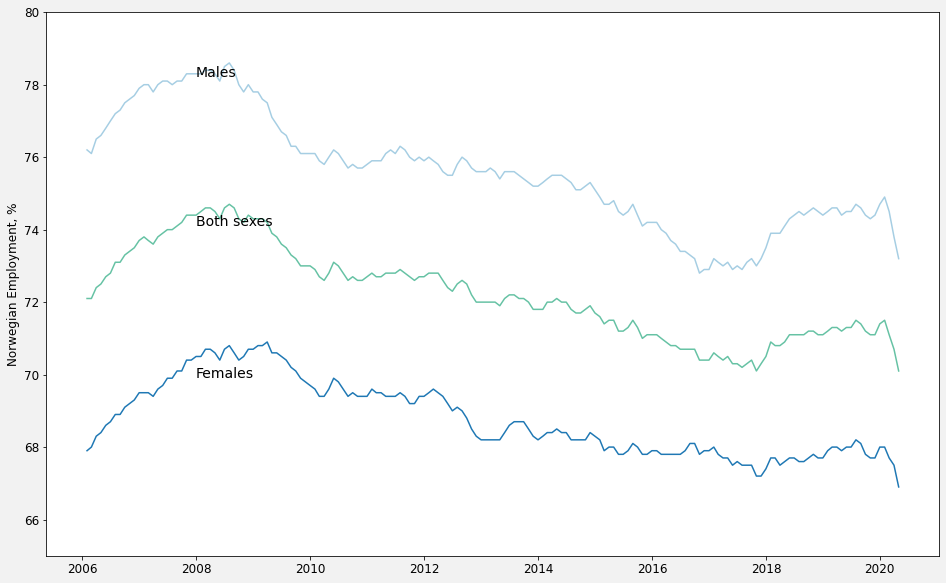

In [316]:
fig, ax = plt.subplots()
emp_by_sex = emp_perc_sa.groupby("sex")
for emp in emp_by_sex:
	ax.plot(emp[1].date, emp[1].value, label=emp[0])
	ax.annotate(emp[0], xy=(start, np.array(emp[1].value)[0]+2))
ax.set_ylabel("Norwegian Employment, %")
ax.set_ylim([65, 80])
fig.savefig("figures/employment.png", bbox_inches='tight')
plt.show()

### Bankruptcies

In [317]:
bankruptcies = pd.read_csv("https://data.ssb.no/api/v0/dataset/95265.csv?lang=en")
enter_bank = bankruptcies[bankruptcies.contents == 'Bankruptcies related to enterprises (excl. sole propriertorships)']
pers_bank = bankruptcies[bankruptcies.contents == 'Personal bankruptcies (incl. sole propriertorships)']


In [318]:
enter_bank.tail()

month                                           contents  \
1500  2020M01  Bankruptcies related to enterprises (excl. sol...   
1505  2020M02  Bankruptcies related to enterprises (excl. sol...   
1510  2020M03  Bankruptcies related to enterprises (excl. sol...   
1515  2020M04  Bankruptcies related to enterprises (excl. sol...   
1520  2020M05  Bankruptcies related to enterprises (excl. sol...   

      07218: Bankruptcies, by month and contents  
1500                                         370  
1505                                         350  
1510                                         334  
1515                                         242  
1520                                         306

In [319]:
#enter_bank = enter_bank[enter_bank.iloc[:,2]!=".."]
#pers_bank = pers_bank[pers_bank.iloc[:,2]!=".."]

def format_df(df):
	df.columns = ["time", "contents", "value"]
	df = df[["time", "value"]]
	df.loc[:, "time"] = df.time.apply(lambda x:  x.replace("M", ""))
	df.loc[:, "time"] = pd.to_datetime(df["time"], format="%Y%m")
	#df.loc[(df.value == ".."), "value"] =np.nan
	df.loc[:, "value"] = df.value.astype(float)
	return(df)

In [320]:
enter_bank.head()
enter_bank.tail()

month                                           contents  \
1500  2020M01  Bankruptcies related to enterprises (excl. sol...   
1505  2020M02  Bankruptcies related to enterprises (excl. sol...   
1510  2020M03  Bankruptcies related to enterprises (excl. sol...   
1515  2020M04  Bankruptcies related to enterprises (excl. sol...   
1520  2020M05  Bankruptcies related to enterprises (excl. sol...   

      07218: Bankruptcies, by month and contents  
1500                                         370  
1505                                         350  
1510                                         334  
1515                                         242  
1520                                         306

In [321]:


enter_bank = format_df(enter_bank)
pers_bank = format_df(pers_bank)

start = datetime.strptime('01012000', '%d%m%Y')




In [322]:
enter_bank.head()
enter_bank.to_csv("data_series/bakruptcies_enterprise.csv")
pers_bank.to_csv("data_series/personal_bankruptcies.csv")

In [323]:
from scipy.interpolate import UnivariateSpline

enter_bank = enter_bank[enter_bank.value.notnull()]
pers_bank = pers_bank[pers_bank.value.notnull()]
t = len(enter_bank.time)
T = [i for i in range(t)]
s_enter = UnivariateSpline(T, enter_bank.value, k=3, s=400000)
smooth_enter = s_enter(T)

In [324]:


s_pers = UnivariateSpline(T, pers_bank.value, k=3, s=200000)
smooth_person = s_pers(T)

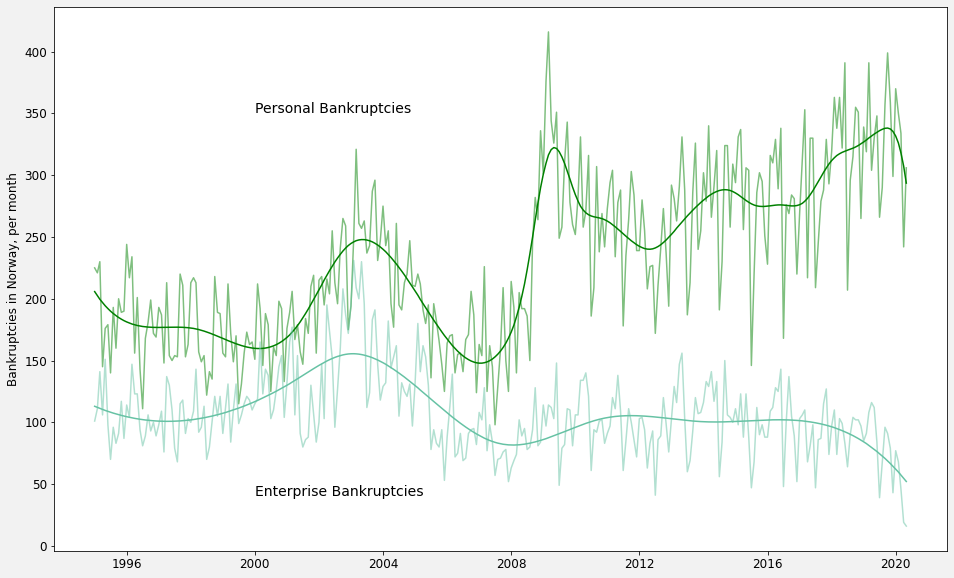

In [325]:
fig, ax = plt.subplots()
ax.plot(enter_bank.time, enter_bank.value, color="green", alpha=.5)
ax.plot(enter_bank.time, smooth_enter, color="green")
ax.plot(pers_bank.time, pers_bank.value, color='#66c2a4', alpha=.5)
ax.plot(pers_bank.time, smooth_person, color='#66c2a4')
ax.annotate('Personal Bankruptcies', xy=(start, 350))
ax.annotate('Enterprise Bankruptcies', xy=(start, 40))
ax.set_ylabel("Bankruptcies in Norway, per month")
fig.savefig("figures/bank_plot.png", bbox_inches='tight')
plt.show()

# Housing Prices

In [326]:
#house_prices = pd.read_csv("https://data.ssb.no/api/v0/dataset/1060.csv", sep=";", header=0, encoding = "cp865")


In [327]:
house_prices = pd.read_csv("https://data.ssb.no/api/v0/dataset/1060.csv", sep=";", header=0, encoding = "cp865")
house_prices.columns = ['region', 'type', 'time', 'variable','value']
time = house_prices.time.apply(lambda x: x.replace("K",""))
month = [str(int(t[-1])*3) for t in time]
year = [str(int(t[:-1])) for t in time]
house_prices["time"] = [x+y for x,y in zip(year, month)]
house_prices["time"] = pd.to_datetime(house_prices.time, format='%Y%m')
na_values = ["..", "."]
house_prices = house_prices[~house_prices.value.isin(na_values)]
house_prices["value"] = house_prices.value.apply(lambda x: float(x.replace(",", ".")))

all_houses = house_prices[house_prices.type=="00 Boliger i alt"]

start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
all_houses = all_houses[all_houses.time>=start]


In [328]:
all_houses.head()
all_houses.variable.unique()

array(['Prisindeks for brukte boliger',
       'Prisindeks for brukte boliger, sesongjustert'], dtype=object)

In [329]:

all_houses = all_houses[all_houses.variable=="Prisindeks for brukte boliger, sesongjustert"]
all_houses.head()

region              type       time  \
105  TOTAL Hele landet  00 Boliger i alt 2005-03-01   
107  TOTAL Hele landet  00 Boliger i alt 2005-06-01   
109  TOTAL Hele landet  00 Boliger i alt 2005-09-01   
111  TOTAL Hele landet  00 Boliger i alt 2005-12-01   
113  TOTAL Hele landet  00 Boliger i alt 2006-03-01   

                                         variable  value  
105  Prisindeks for brukte boliger, sesongjustert   53.2  
107  Prisindeks for brukte boliger, sesongjustert   54.0  
109  Prisindeks for brukte boliger, sesongjustert   55.2  
111  Prisindeks for brukte boliger, sesongjustert   56.8  
113  Prisindeks for brukte boliger, sesongjustert   58.7

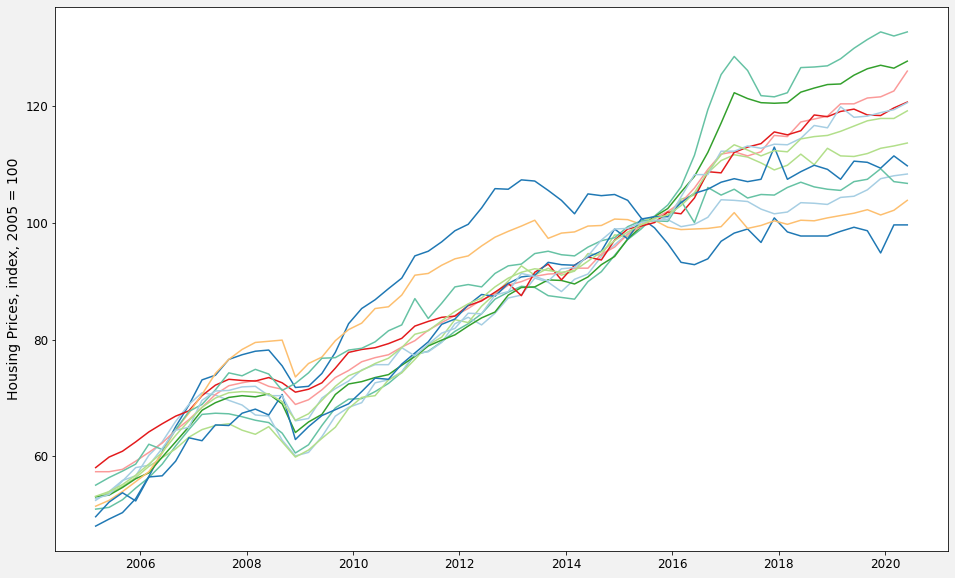

In [330]:
fig, ax = plt.subplots()
houses_by_region= all_houses.groupby("region")
for region in houses_by_region:
	ax.plot(region[1].time, region[1].value, label=region[0])
	#ax.legend()
	#n = len(region[1].value)
	#ax.annotate(region[0], xy=(end, region[1].value[0]) )
ax.set_ylabel("Housing Prices, index, 2005 = 100", size=14)
fig.savefig("figures/housing_prices.png", bbox_inches='tight')
plt.show()

In [331]:
names = []
prices_by_region = house_prices.groupby("region")
for region in prices_by_region:
	names.append(region[0])

In [332]:
prices_by_region.head()
names

['001 Oslo med Bµrum',
 '002 Stavanger',
 '003 Bergen',
 '004 Trondheim',
 '005 Akershus uten Bµrum',
 '006 Vestfold og Telemark og Viken uten Akershus',
 '007 Innlandet',
 '008 Agder og Rogaland uten Stavanger',
 '009 M°re og Romsdal og Vestland uten Bergen',
 '010 Tr°ndelag uten Trondheim',
 '011 Nord-Norge',
 'TOTAL Hele landet']

In [333]:

cities = ["002 Stavanger", "004 Trondheim", "003 Bergen", "001 Oslo med Bµrum"]

house_prices_cities = house_prices[house_prices.region.isin(cities)]
total_cities = house_prices_cities[house_prices_cities.type == "00 Boliger i alt"]
total_cities = total_cities[total_cities.variable == "Prisindeks for brukte boliger, sesongjustert"]



In [334]:
start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
total_cities = total_cities[total_cities.time>=start]


In [335]:
total_cities.head()

region              type       time  \
1017  001 Oslo med Bµrum  00 Boliger i alt 2005-03-01   
1019  001 Oslo med Bµrum  00 Boliger i alt 2005-06-01   
1021  001 Oslo med Bµrum  00 Boliger i alt 2005-09-01   
1023  001 Oslo med Bµrum  00 Boliger i alt 2005-12-01   
1025  001 Oslo med Bµrum  00 Boliger i alt 2006-03-01   

                                          variable  value  
1017  Prisindeks for brukte boliger, sesongjustert   51.0  
1019  Prisindeks for brukte boliger, sesongjustert   51.3  
1021  Prisindeks for brukte boliger, sesongjustert   52.6  
1023  Prisindeks for brukte boliger, sesongjustert   54.6  
1025  Prisindeks for brukte boliger, sesongjustert   56.4

In [336]:
houses_by_city= total_cities.groupby("region")

In [337]:
total_cities.head()

region              type       time  \
1017  001 Oslo med Bµrum  00 Boliger i alt 2005-03-01   
1019  001 Oslo med Bµrum  00 Boliger i alt 2005-06-01   
1021  001 Oslo med Bµrum  00 Boliger i alt 2005-09-01   
1023  001 Oslo med Bµrum  00 Boliger i alt 2005-12-01   
1025  001 Oslo med Bµrum  00 Boliger i alt 2006-03-01   

                                          variable  value  
1017  Prisindeks for brukte boliger, sesongjustert   51.0  
1019  Prisindeks for brukte boliger, sesongjustert   51.3  
1021  Prisindeks for brukte boliger, sesongjustert   52.6  
1023  Prisindeks for brukte boliger, sesongjustert   54.6  
1025  Prisindeks for brukte boliger, sesongjustert   56.4

In [338]:
for city in houses_by_city:
    print(city[0])

001 Oslo med Bµrum
002 Stavanger
003 Bergen
004 Trondheim


In [339]:
total_cities.to_csv("data_series/housing_prices.csv")

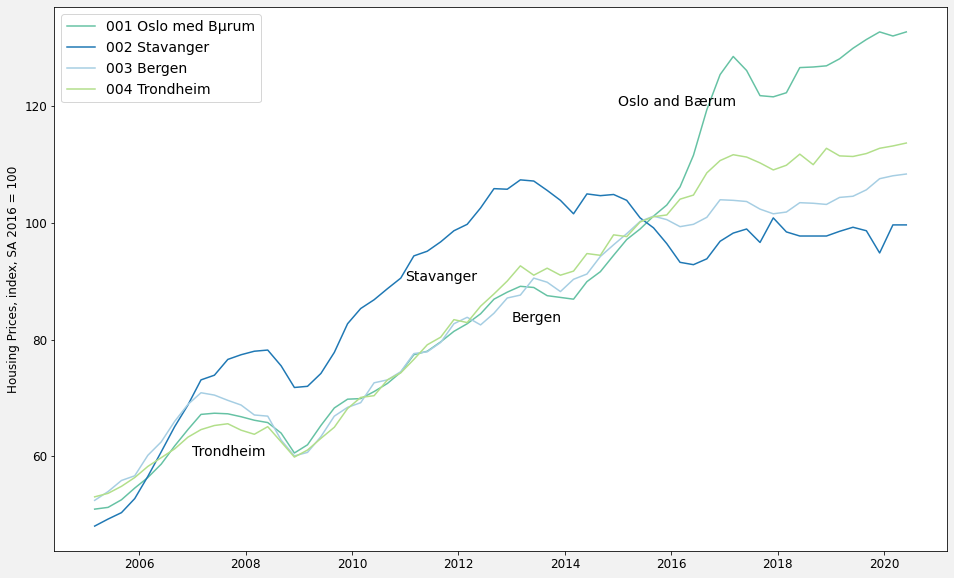

In [340]:
fig, ax = plt.subplots()
for city in houses_by_city:
	ax.plot(city[1].time, city[1].value, label=city[0])
	ax.legend()
	#n = len(region[1].value)
ax.annotate("Trondheim", xy=(datetime.strptime('01012007', '%d%m%Y'),60))
ax.annotate("Bergen", xy=(datetime.strptime('01012013', '%d%m%Y'),83))
ax.annotate("Stavanger", xy=(datetime.strptime('01012011', '%d%m%Y'),90))
ax.annotate("Oslo and Bærum", xy=(datetime.strptime('01012015', '%d%m%Y'),120))

ax.set_ylabel("Housing Prices, index, SA 2016 = 100")
fig.savefig("figures/city_housing_prices.png", bbox_inches='tight')
plt.show()

#### Long term housing costs

In [341]:
xls_housing = pd.ExcelFile("http://www.norges-bank.no/WebDAV/hms/data/HousePrices.xlsx")
house_prices_l = xls_housing.parse('Table_A1', header=2)
house_prices_l.columns = ["year", "total", "oslo", "bergen", "trondheim", "kristiansand"]
house_prices_l = house_prices_l.iloc[15:,:]


XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b'\r\n<!DOCT'

In [342]:
house_prices_melt = pd.melt(house_prices_l, id_vars="year")
house_prices_melt["value"][house_prices_melt.value==" "] = np.nan
house_prices_melt["value"] =house_prices_melt.value.astype(float)


NameError: name 'house_prices_l' is not defined

In [220]:
house_prices_melt.tail()
house_prices_melt.loc[:, "year"] = pd.to_datetime(house_prices_melt.year, format="%Y")

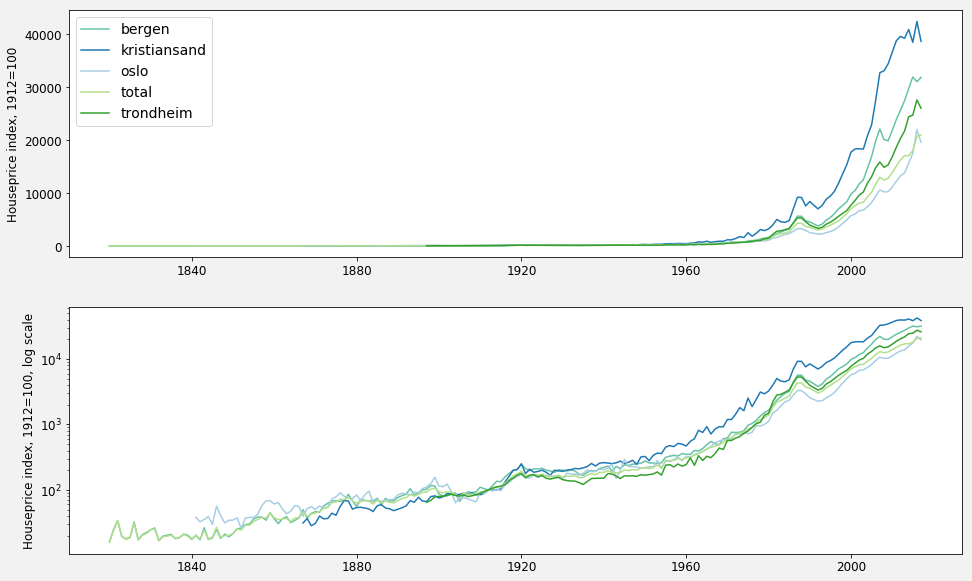

In [221]:
fig, ax = plt.subplots(2)
hp_by_city = house_prices_melt.groupby("variable")

for city_price in hp_by_city:
	ax[0].plot(city_price[1].year, city_price[1].value, label=city_price[0])
	#ax[0].text(2016, np.array(city_price[1].value)[-2], city_price[0], size=16)
ax[0].legend()
ax[0].set_ylabel("Houseprice index, 1912=100")

for city_price in hp_by_city:
	ax[1].plot(city_price[1].year, city_price[1].value, label=city_price[0])
ax[1].set_ylabel("Houseprice index, 1912=100, log scale")
ax[1].set_yscale('log')
#fig.set_size_inches(16,18)
fig.savefig("figures/houseprices_long.png")
plt.show()

### Housing Cost Index

In [343]:
cost_index = pd.read_csv("http://data.ssb.no/api/v0/dataset/26944.csv?lang=en", sep=",", decimal=".", na_values=["..", "."])


ConnectionResetError: [Errno 54] Connection reset by peer

In [ ]:
cost_index.head()

In [ ]:
cost_index.columns = ['type', 'date', 'variable','index']
cost_index["date"] = pd.to_datetime(cost_index.date, format="%YM%m")

tot_cost_index = cost_index[cost_index.type=="01 Total"]
del tot_cost_index["type"]
tot_cost_index_w = tot_cost_index.pivot(index="date", columns = "variable", values="index")
tot_cost_index_w.head()

In [ ]:
tot_cost_index_w.columns = ['% change, mom', '% change, yoy', 'cost index']
tot_cost_index_w.reset_index(inplace=True)

In [ ]:
tot_cost_index_w.to_csv("data_series/housing_build_cost.csv")

NameError: name 'tot_cost_index_w' is not defined

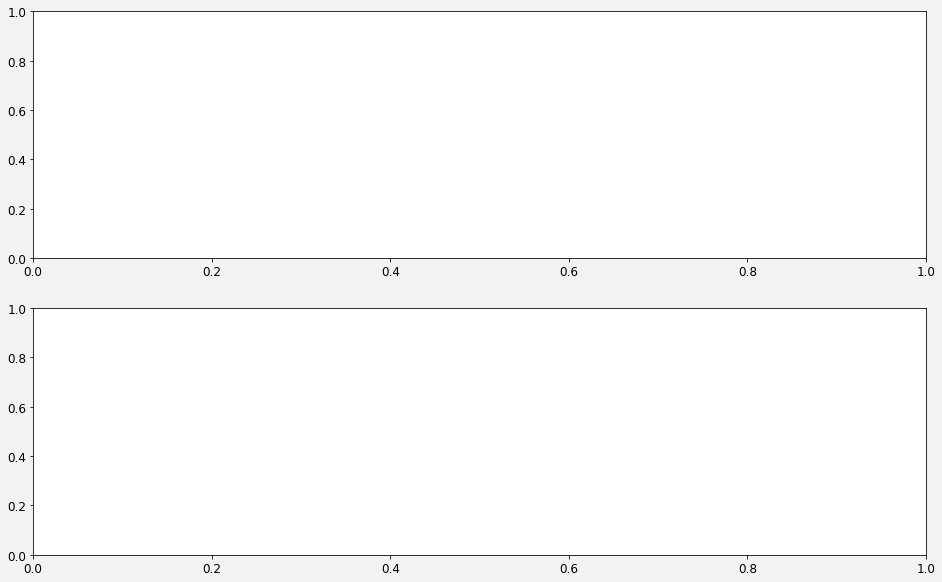

In [344]:
fig, ax = plt.subplots(2)
ax[0].plot(tot_cost_index_w.date, tot_cost_index_w["cost index"])
ax[1].plot(tot_cost_index_w.date, tot_cost_index_w["% change, yoy"])
plt.show()

In [228]:
tot_price_index = house_prices[house_prices.type == "00 Boliger i alt"]



In [229]:
tot_price_index = tot_price_index[tot_price_index.region =="Total"]
tot_price_index = tot_price_index[tot_price_index.variable == "Prisindeks for brukte boliger, sesongjustert"]
#tot_price_index = tot_price_index[["time", "value"]]
#tot_price_index = tot_price_index.pivot(index="time", columns="region", values="value")


In [230]:
tot_price_index.head()

Empty DataFrame
Columns: [region, type, time, variable, value]
Index: []

In [231]:
#tot_price_index.reset_index(inplace=True)


In [232]:

tot_price_index["% change, yoy"] = tot_price_index.value.pct_change(periods=4)*100
#tot_price_index.reset_index(inplace=True)


In [233]:
tot_cost_index_w.head()

date  % change, mom  % change, yoy  cost index
0 1978-01-01            NaN            NaN        35.6
1 1978-02-01            0.3            NaN        35.7
2 1978-03-01            0.3            NaN        35.8
3 1978-04-01            0.6            NaN        36.0
4 1978-05-01            0.0            NaN        36.0

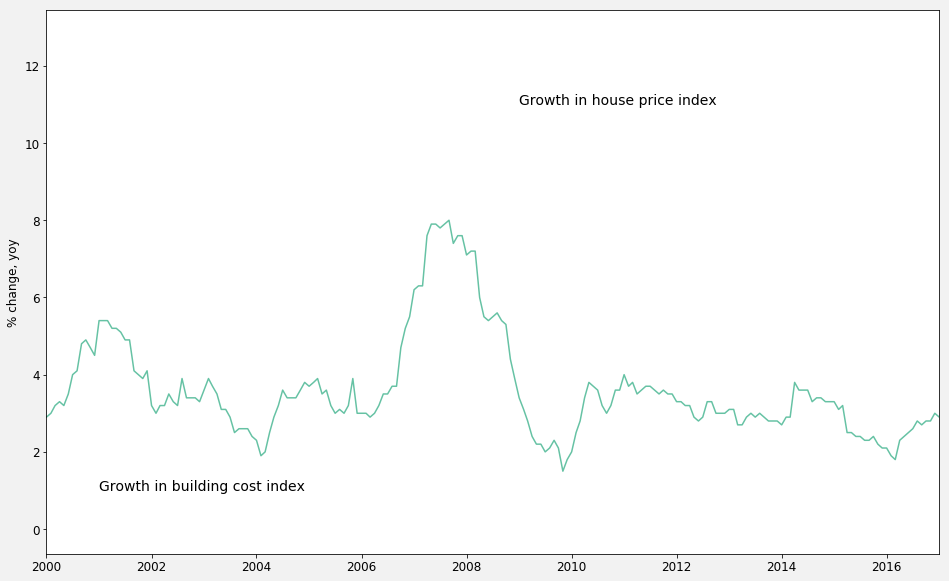

In [234]:

fig, ax = plt.subplots()
ax.plot(tot_cost_index_w.date, tot_cost_index_w["% change, yoy"])
ax.plot(tot_price_index.time, tot_price_index["% change, yoy"])
ax.set_xlim([pd.to_datetime("2000-01-01"), pd.to_datetime("2017-01-01")])
ax.set_ylabel("% change, yoy")
ax.annotate("Growth in house price index", xy=(datetime.strptime('01012009', '%d%m%Y'),11))
ax.annotate("Growth in building cost index", xy=(datetime.strptime('01012001', '%d%m%Y'),1))
fig.savefig("figures/building_cost.png")
plt.show()

### New housing starts, principalities with major cities

In [345]:
bygging = pd.read_csv("http://data.ssb.no/api/v0/dataset/26025.csv?lang=no", sep=";", header=0, decimal=",", encoding = "cp865")
bygging["region"]=bygging.region.astype('category')

fylker = ['Oestfold', 'Akershus', 'Oslo', 'Hedmark', 'Oppland',
       'Buskerud', 'Vestfold', 'Telemark', 'Aust-Agder',
       'Vest-Agder', 'Rogaland', 'Hordaland', 'Sogn og Fjordane',
       'Moere og Romsdal', "Trøndelag", 'Soer-Troendelag', 'Nord-Troendelag',
       'Nordland', 'Troms', 'Finnmark',
       'Svalbard']

In [355]:
regions = bygging.region.unique()

In [356]:
regions

[30 Viken, 01 ╪stfold (-2019), 02 Akershus (-2019), 06 Buskerud (-2019), 03 Oslo, ..., 23 Kontinentalsokkelen, 25 Utlandet, 26 Havomrσder, 88 Ikke bosatt i Norge, 99 Uoppgitt fylke]
Length: 34
Categories (34, object): [30 Viken, 01 ╪stfold (-2019), 02 Akershus (-2019), 06 Buskerud (-2019), ..., 25 Utlandet, 26 Havomrσder, 88 Ikke bosatt i Norge, 99 Uoppgitt fylke]

In [346]:
bygging["region"] = bygging.region.cat.rename_categories(fylker)



ValueError: new categories need to have the same number of items as the old categories!

In [246]:
bygging.head()

region    mσned                   statistikkvariabel  \
0  Oestfold  1993M01                   Igangsatte boliger   
1  Oestfold  1993M01      Igangsatt bruksareal (1 000 m2)   
2  Oestfold  1993M01                 Boliger under arbeid   
3  Oestfold  1993M01  Under arbeid, bruksareal (1 000 m�)   
4  Oestfold  1993M01                   Fullfoerte boliger   

   03723: Boligbygg, etter region, mσned og statistikkvariabel  
0                                               35.0            
1                                                4.2            
2                                              594.0            
3                                               95.7            
4                                              148.0

In [248]:
bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
bygging.statistikkvariabel.cat.categories
variabler = ['Boliger under arbeid', 'Fullfoert bruksareal (1 000 m2)',
       'Fullfoerte boliger', 'Igangsatt bruksareal (1 000 m2)',
       'Igangsatte boliger', 'Under arbeid, bruksareal (1 000 m�)']
bygging["statistikkvariabel"] = bygging.statistikkvariabel.cat.rename_categories(variabler)
bygging.rename(columns={"Boligbygg, etter region, statistikkvariabel og tid": "boligbygging"}, inplace=True)
bygging["tid"] = pd.to_datetime(bygging["mσned"], format="%YM%m")
bygging["boligbygging"]=bygging.boligbygging.astype(float)



AttributeError: 'DataFrame' object has no attribute 'boligbygging'

In [ ]:
igangsatte = bygging[bygging.statistikkvariabel == "Igangsatte boliger"]
rel_fylker = ['Oslo', 'Rogaland', 'Hordaland',  'Soer-Troendelag']
igangsatte = igangsatte[bygging.region.isin(rel_fylker)]
igangsatte["region"] = igangsatte.region.astype('str')


#### Smoothing

In [ ]:
from scipy.interpolate import UnivariateSpline

igangsatte = igangsatte[igangsatte.boligbygging.notnull()]

#bygging_by_city = igangsatte.groupby("region")
Oslo = igangsatte[igangsatte.region=="Oslo"]
Hordaland = igangsatte[igangsatte.region=="Hordaland"]
Rogaland = igangsatte[igangsatte.region =="Rogaland"]
Soer_Troendelag = igangsatte[igangsatte.region=="Soer-Troendelag"]

#smooth the city data
d = {"date":igangsatte["tid"][igangsatte.region=="Oslo"]}
smooth_data = pd.DataFrame(data=d)
t = len(Oslo.tid)
T = [i for i in range(t)]

s_city = UnivariateSpline(T, Oslo.boligbygging, k=3, s=6000000)
smooth_data["Oslo"] = s_city(T)

s_city = UnivariateSpline(T, Hordaland.boligbygging, k=3, s=2000000)
smooth_data["Hordaland"] = s_city(T)

s_city = UnivariateSpline(T, Rogaland.boligbygging, k=3, s=2000000)
smooth_data["Rogaland"] = s_city(T)

s_city = UnivariateSpline(T, Soer_Troendelag.boligbygging, k=3, s=2000000)
smooth_data["Soer-Troendelag"] = s_city(T)

smooth_data_l = pd.melt(smooth_data, id_vars = "date")

smooth_by_city = smooth_data_l.groupby("variable")


In [228]:
bygging_by_city = igangsatte.groupby("region")
fig, ax = plt.subplots(4)
for a, city in enumerate(smooth_by_city):
	ax[a].plot(city[1].date, city[1].value)
	ax[a].set_ylabel(city[0], size=14)

for a, city in enumerate(bygging_by_city):
	ax[a].plot(city[1].tid, city[1].boligbygging, alpha=.2, color="blue")
	#n = len(region[1].value)
#ax.set_ylabel("Number of new dwellings", size=14)
ax[3].set_xlabel("New housing starts, by principality with major city")
fig.savefig("figures/city_new_housing_starts.png")
plt.show()

NameError: name 'igangsatte' is not defined

### Entire Country

In [357]:
bygging = pd.read_csv("http://data.ssb.no/api/v0/dataset/95146.csv?lang=no", sep=";", header=0, decimal=",", encoding = "cp865")
bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
bygging.statistikkvariabel.cat.categories

Index(['Boliger under arbeid', 'Fullf°rt bruksareal (1 000 m▓)',
       'Fullf°rte boliger', 'Igangsatt bruksareal (1 000 m▓)',
       'Igangsatte boliger', 'Under arbeid, bruksareal (1 000 m▓)'],
      dtype='object')

In [358]:
bygging = pd.read_csv("http://data.ssb.no/api/v0/dataset/95146.csv?lang=no", sep=";", header=0, decimal=",", encoding = "cp865")
bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
bygging.statistikkvariabel.cat.categories
variabler = ['Boliger under arbeid', 'Fullfoert bruksareal (1 000 m2)',
       'Fullfoerte boliger', 'Igangsatt bruksareal (1 000 m2)',
       'Igangsatte boliger', 'Under arbeid, bruksareal (1 000 m2)']
bygging["statistikkvariabel"] = bygging.statistikkvariabel.cat.rename_categories(variabler)
bygging.rename(columns={"Boligbygg, etter region, statistikkvariabel og tid": "boligbygging"}, inplace=True)

In [359]:
bygging.columns = ["region", "statistikkvariabel", "tid", "boligbygging"]

In [360]:

bygging["tid"] = pd.to_datetime(bygging.tid, format="%YM%m")
bygging["boligbygging"]=bygging.boligbygging.astype(float)

igangsatte = bygging[bygging.statistikkvariabel == "Igangsatte boliger"]
t = len(igangsatte.tid)
T = [i for i in range(t)]

s_igangsatte = UnivariateSpline(T, igangsatte.boligbygging, k=3, s=50000000)
smooth_igangsatte = s_igangsatte(T)


In [361]:
bygging.head()
bygging.to_csv("data_series/igangsatte_boliger.csv")

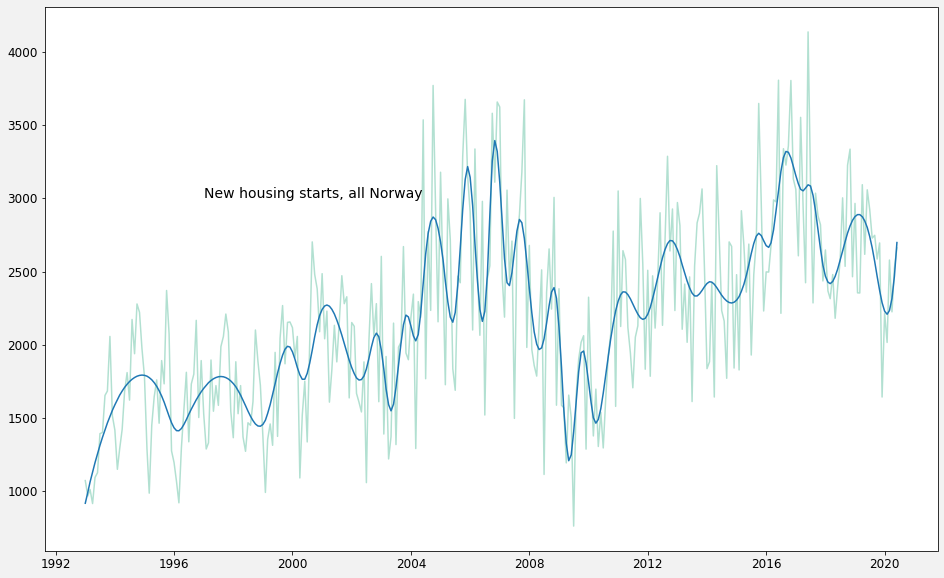

In [362]:
fig, ax = plt.subplots()
ax.plot(igangsatte.tid, igangsatte.boligbygging, alpha=.5)
ax.plot(igangsatte.tid, smooth_igangsatte)
ax.annotate("New housing starts, all Norway", xy=(datetime.strptime('01011997', '%d%m%Y'),3000))
fig.savefig("figures/new_housing_starts.png")
plt.show()

## Credit and Debt

In [363]:
#credit
#debt_json = pd.read_json("https://data.ssb.no/api/v0/dataset/62264.json?lang=no")

debt = pd.read_csv("https://data.ssb.no/api/v0/dataset/62264.csv?lang=no", sep=";", na_values = [".", ".."], encoding = "cp865")
debt.columns = ['currency', 'sector', 'credit_source', 'time', 'variable','value']

debt["time"] = convert_datetime(debt.time)
debt["value"] = debt.value.astype(float)
debt["value"] = debt["value"]/1000

by_source = debt.groupby("credit_source")
for source in by_source:
	print(source[0])

by_sector = debt.groupby("sector")
for sect in by_sector:
	print(sect[0])

total_sources = debt[debt.credit_source=='LTOT Lσnegjeld i alt']
total_sources = total_sources[total_sources.currency=="00 I alt"]




L201 Lσn fra statlige lσneinstitutter
L202 Lσn fra banker
L202+L203 Lσn fra banker og kredittforetak
L203 Lσn fra kredittforetak
L204 Lσn fra finansieringsforetak
L206 Lσn fra livsforsikringsselskaper
L207 Lσn fra skadeforsikringsselskaper
L209 Lσn fra pensjonskasser
L210 Obligasjonsgjeld
L211 Sertifikatgjeld
L212 Lσn fra andre sektorer
L214 Verdipapirlσn
LTOT Lσnegjeld i alt
Kred01 Publikum
Kred02 Kommuneforvaltningen
Kred03 Ikke-finansielle foretak
Kred04 Husholdninger mv.


In [364]:
debt.credit_source.unique()

array(['LTOT Lσnegjeld i alt',
       'L202+L203 Lσn fra banker og kredittforetak',
       'L202 Lσn fra banker', 'L201 Lσn fra statlige lσneinstitutter',
       'L203 Lσn fra kredittforetak', 'L204 Lσn fra finansieringsforetak',
       'L206 Lσn fra livsforsikringsselskaper',
       'L207 Lσn fra skadeforsikringsselskaper',
       'L209 Lσn fra pensjonskasser', 'L212 Lσn fra andre sektorer',
       'L214 Verdipapirlσn', 'L210 Obligasjonsgjeld',
       'L211 Sertifikatgjeld'], dtype=object)

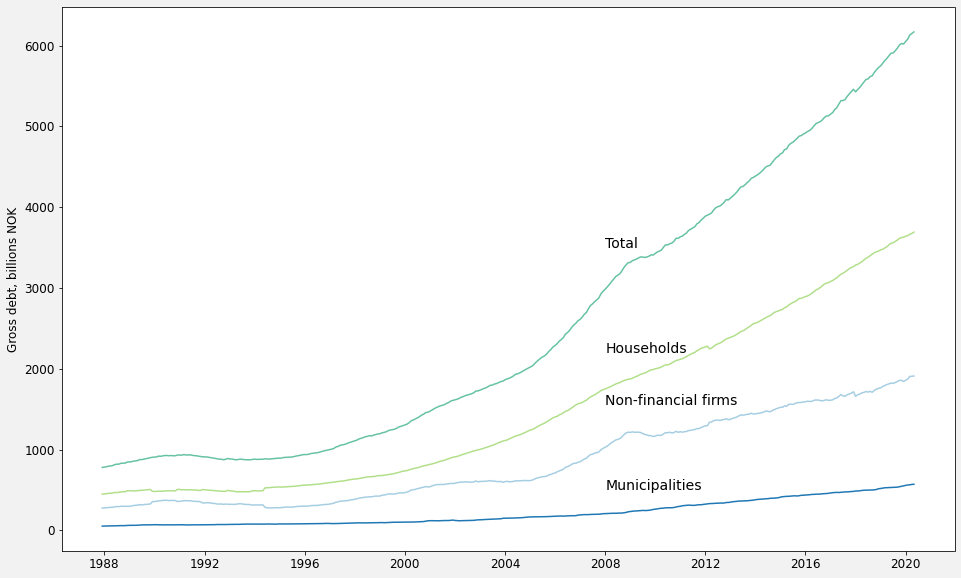

In [365]:
start = datetime.strptime('01012008', '%d%m%Y')
fig, ax = plt.subplots()
tot_by_sector = total_sources.groupby("sector")
for sect in tot_by_sector:
	ax.plot(sect[1].time, sect[1].value, label=sect[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("200801"),3500))
ax.annotate("Households", xy=(yearmonth("200801"), 2200))
ax.annotate("Non-financial firms", xy=(yearmonth("200801"), 1550))
ax.annotate("Municipalities", xy=(yearmonth("200801"), 500))
ax.set_ylabel("Gross debt, billions NOK")
fig.savefig("figures/debt_by_sector.png")
plt.show()


In [366]:
total_sources.to_csv("data_series/debt_by_sector.csv")

###   household debt by source

In [367]:
debt = debt[debt.value.notnull()]
debt = debt[debt.value!=0]

In [368]:
debt.sector.unique()

array(['Kred01 Publikum', 'Kred02 Kommuneforvaltningen',
       'Kred03 Ikke-finansielle foretak', 'Kred04 Husholdninger mv.'],
      dtype=object)

In [369]:
household = debt[debt.sector=="Kred04 Husholdninger mv."]
household = household[household.currency =="00 I alt"]
household.credit_source.unique()

array(['LTOT Lσnegjeld i alt',
       'L202+L203 Lσn fra banker og kredittforetak',
       'L202 Lσn fra banker', 'L201 Lσn fra statlige lσneinstitutter',
       'L203 Lσn fra kredittforetak', 'L204 Lσn fra finansieringsforetak',
       'L206 Lσn fra livsforsikringsselskaper',
       'L207 Lσn fra skadeforsikringsselskaper',
       'L209 Lσn fra pensjonskasser', 'L212 Lσn fra andre sektorer',
       'L210 Obligasjonsgjeld', 'L211 Sertifikatgjeld'], dtype=object)

In [370]:



source_inc = ['L202 Lσn fra banker',
       'L201 Lσn fra statlige lσneinstitutter', 'L203 Lσn fra kredittforetak']

household = household[household.credit_source.isin(source_inc)]


In [375]:
household.tail()

currency                    sector                credit_source  \
17126  00 I alt  Kred04 Husholdninger mv.  L203 Lσn fra kredittforetak   
17127  00 I alt  Kred04 Husholdninger mv.  L203 Lσn fra kredittforetak   
17128  00 I alt  Kred04 Husholdninger mv.  L203 Lσn fra kredittforetak   
17129  00 I alt  Kred04 Husholdninger mv.  L203 Lσn fra kredittforetak   
17130  00 I alt  Kred04 Husholdninger mv.  L203 Lσn fra kredittforetak   

            time               variable     value  
17126 2017-08-01  Innenlandsk lσnegjeld  1356.645  
17127 2017-09-01  Innenlandsk lσnegjeld  1364.915  
17128 2017-10-01  Innenlandsk lσnegjeld  1378.749  
17129 2017-11-01  Innenlandsk lσnegjeld  1381.427  
17130 2017-12-01  Innenlandsk lσnegjeld  1403.369

In [372]:

household_by_source = household.groupby("credit_source")


In [373]:
household.to_csv("data_series/household_debt.csv")

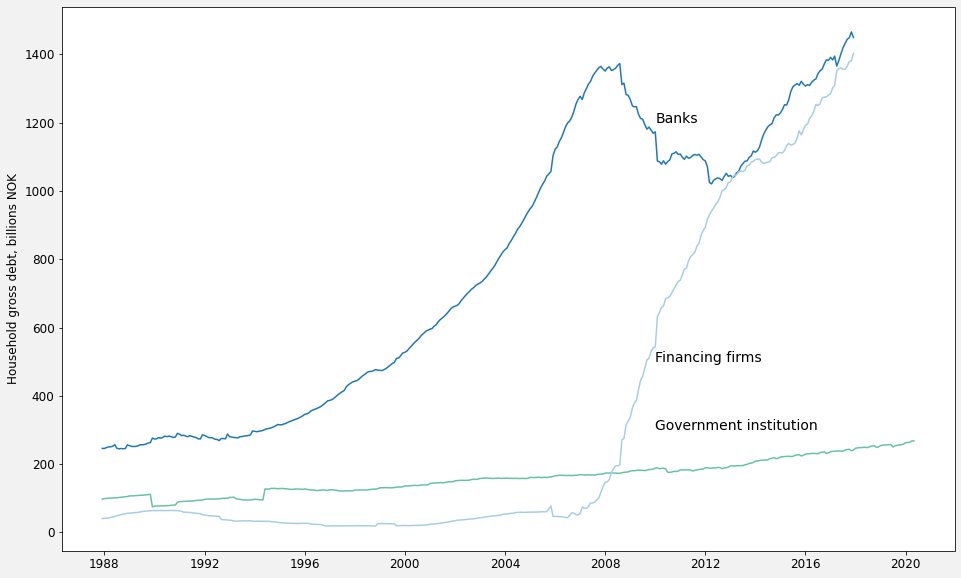

In [374]:
fig, ax = plt.subplots()

for source in household_by_source:
	ax.plot(source[1].time, source[1].value, label=source[0])
#ax.legend()
#ax.annotate("Total", xy=(yearmonth("201001"),2300))
ax.annotate("Banks", xy=(yearmonth("201001"), 1200))
ax.annotate("Financing firms", xy=(yearmonth("201001"), 500))
ax.annotate("Government institution", xy=(yearmonth("201001"), 300))
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Household gross debt, billions NOK")
fig.savefig("figures/household_debt_by_source.png")
plt.show()

#### by currency

In [268]:
household.credit_source.unique()

array(['LTOT Lσnegjeld i alt', 'L202 Lσn fra banker',
       'L201 Lσn fra statlige lσneinstitutter',
       'L203 Lσn fra kredittforetak', 'L204 Lσn fra finansieringsforetak',
       'L206 Lσn fra livsforsikringsselskaper',
       'L207 Lσn fra skadeforsikringsselskaper',
       'L209 Lσn fra pensjonskasser', 'L212 Lσn fra andre sektorer',
       'L210 Obligasjonsgjeld', 'L211 Sertifikatgjeld'], dtype=object)

In [266]:
household = debt[debt.sector=="Kred04 Husholdninger mv."]



In [269]:
household = household[household.credit_source == "LTOT Lσnegjeld i alt"]



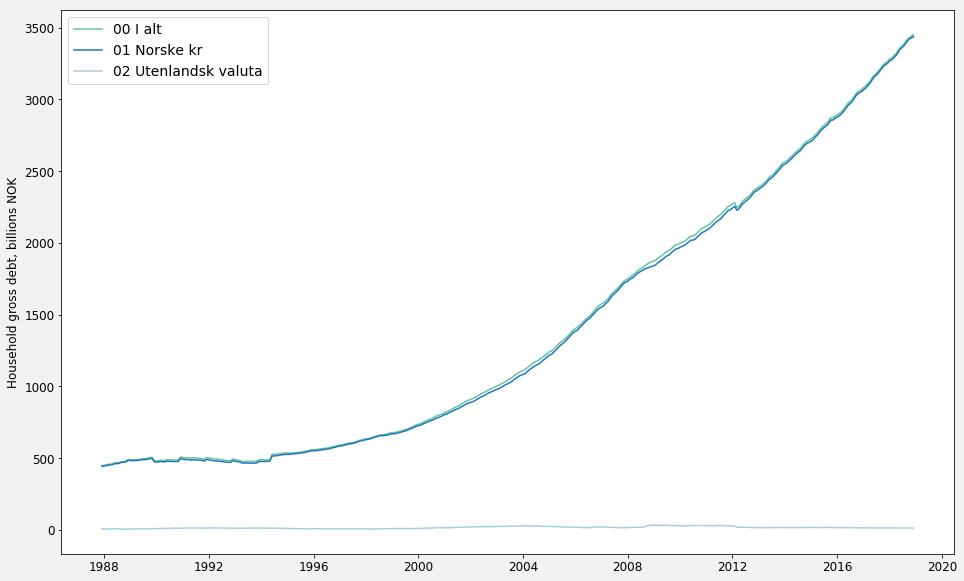

In [270]:

fig, ax = plt.subplots()
household_by_currency = household.groupby("currency")
for currency in household_by_currency:
	ax.plot(currency[1].time, currency[1].value, label=currency[0])
ax.legend()
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Household gross debt, billions NOK")
plt.show()

#### Non-financial firms

In [376]:
firms = debt[debt.sector=="Kred03 Ikke-finansielle foretak"]
firms = firms[firms.currency =="00 I alt"]

firms_inc = ["L201 Statlige l�neinstitutter",
"L202 Banker",
"L203 Kredittforetak",
"L204 Finansieringsselskaper",
"L206 Livsforsikringsselskaper",
"L207 Skadeforsikringsselskaper",
"L209 Pensjonskasser",
"L210 Obligasjonsgjeld",
"L211 Sertifikatgjeld",
"L212 Andre kilder",
"LTOT Kredittkilder i alt"]

#firms = firms[firms.credit_source.isin(source_inc)]

firms.to_csv("data_series/firm_debt.csv")

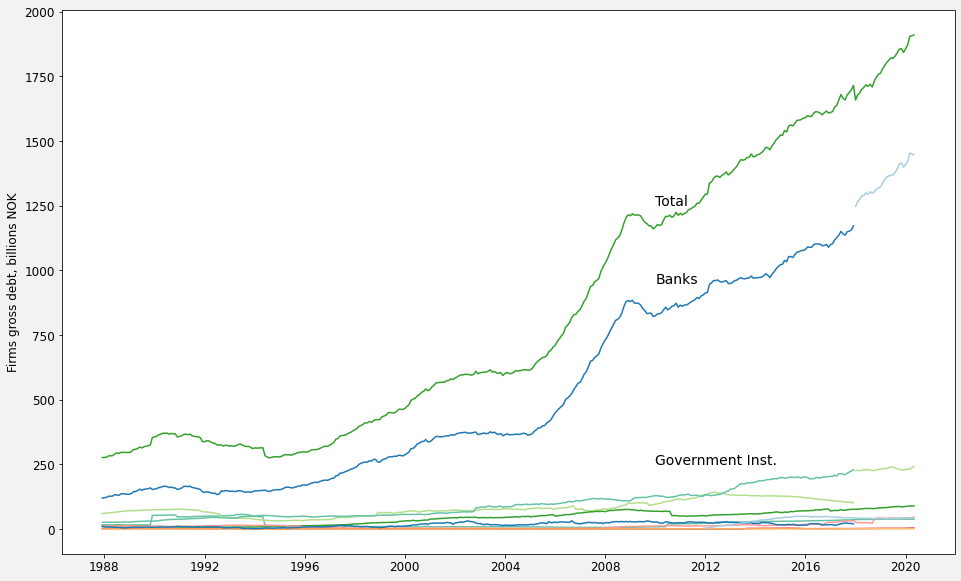

In [377]:
fig, ax = plt.subplots()
firms_by_source = firms.groupby("credit_source")
for source in firms_by_source:
	ax.plot(source[1].time, source[1].value, label=source[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("201001"),1250))
ax.annotate("Banks", xy=(yearmonth("201001"), 950))
ax.annotate("Government Inst.", xy=(yearmonth("201001"), 250))
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Firms gross debt, billions NOK")
fig.savefig("figures/firm_debt_by_source.png")
plt.show()

### KPI

KPI: Konsumprisindeksen. Kilde: Statistisk sentralbyrå

KPI-JAE: KPI justert for avgiftsendringer og uten energivarer. Kilde: Statistisk sentralbyrå

KPIXE: KPI justert for avgiftsendringer og uten midlertidige endringer i energipriser. (Beregningsmetoden ble endret fra og med KPIXE for juni 2013, se Endret beregningsmetode for KPIXE. Modellen for å anslå bensinpriser til beregning av KPIXE ble endret fra og med KPIXE for mars 2016, se Ny modell for å anslå bensinpris til beregning av KPIXE.)

Trimmet snitt (20 prosent): Et trimmet gjennomsnitt av tolvmånedersveksten i delindeksene i KPI justert for avgiftsendringer (KPI-JA). Kilde: Statistisk sentralbyrå

Vektet median: Vektet median av tolvmånedersveksten i delindeksene i KPI-JA. Kilde: Statistisk sentralbyrå


In [378]:
kpi = pd.read_csv("https://static.norges-bank.no/globalassets/marketdata/ppo/kpi/kpi_tab_en.csv")
kpi.columns = ["date", "KPI", "KPI-JAE", "KPIXE", "trimmet_snitt", "vektet_median"]
kpi.loc[:,"date"] = [datetime.strptime(d, "%b.%y") for d in kpi.date]
kpi.head()


date  KPI  KPI-JAE  KPIXE  trimmet_snitt  vektet_median
0 2006-01-01  1.8      0.8    1.3            1.6            1.7
1 2006-02-01  2.6      1.0    1.4            1.7            1.8
2 2006-03-01  2.3      0.8    1.4            1.5            1.6
3 2006-04-01  2.7      0.8    1.3            1.5            1.8
4 2006-05-01  2.3      0.8    1.2            1.5            1.6

In [379]:
kpi.to_csv("data_series/kpi.csv", index=False)

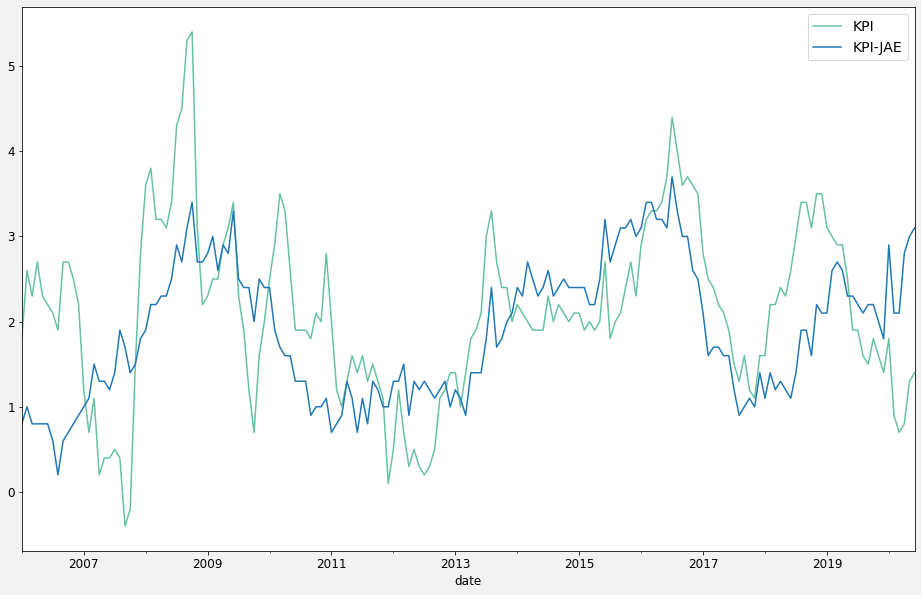

In [380]:
ax = kpi.plot(x="date", y="KPI")
kpi.plot(x="date", y="KPI-JAE", ax=ax)
#kpi.plot(x="date", y="trimmet_snitt", ax=ax)
fig = ax.get_figure()
fig.savefig('figures/kpi.pdf')

#### Interest rates

In [381]:
ir=pd.read_csv("http://www.norges-bank.no/WebDAV/stat/en/renter/v2/renter_mnd.csv")

ir["DATES"] = [datetime.strptime(d, "%b-%y") for d in ir.DATES]

ir.columns = ['date', 'folio_nom', 'res_nom', 'dlaan_nom',
	   'statskvl_3m_eff','statskvl_6m_eff', 'statskvl_9m_eff', 
	   'statskvl_12m_eff','statsobl_3y_eff', 'statsobl_5y_eff', 
	   'statsobl_10y_eff', 'nowa_rt','nowa_vl']



include = ['date','dlaan_nom', 'statskvl_3m_eff', 'statskvl_12m_eff', 'statsobl_10y_eff']
ir = ir[include]
ir.to_csv("data_series/int_rates.csv")

ParserError: Error tokenizing data. C error: Expected 1 fields in line 6, saw 942


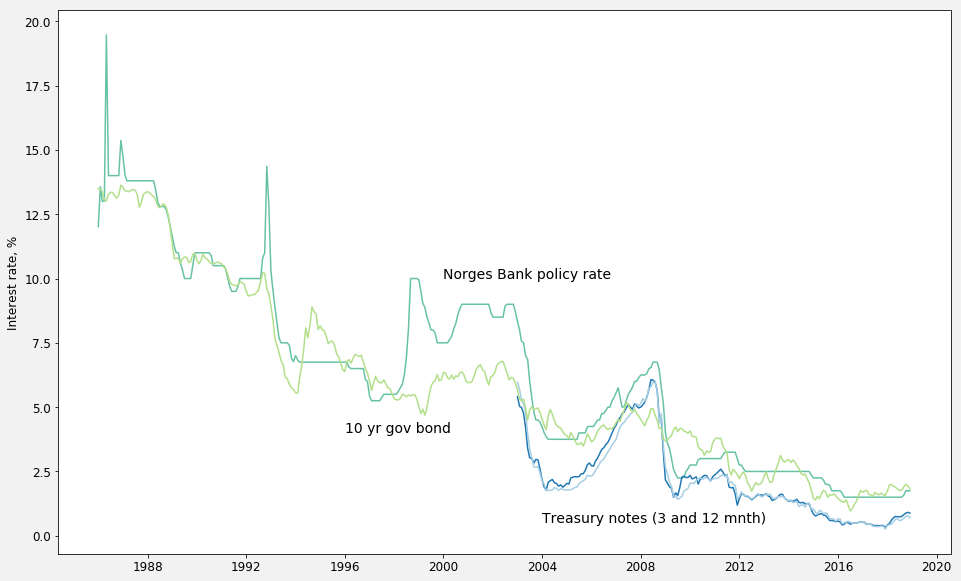

In [277]:
ir_long = pd.melt(ir, id_vars="date")
ir_long["value"][ir_long.value=="ND"] = np.nan
ir_long["value"] = ir_long.value.astype(float)

fig, ax = plt.subplots()
for r in ir_long.groupby("variable"):
	ax.plot(r[1].date, r[1].value, label=r[0])
ax.text(yearmonth("200001"), 10, "Norges Bank policy rate")
ax.text(yearmonth("200401"), .5, "Treasury notes (3 and 12 mnth)")
ax.text(yearmonth("199601"), 4, "10 yr gov bond")
ax.set_ylabel("Interest rate, %")
fig.savefig("figures/interest_rates.png")
plt.show()

#### Historical interest rates and inflation

In [382]:
long_ir = pd.ExcelFile("http://www.norges-bank.no/WebDAV/hms/data/ShortTerm_IR.xlsx")
real_ir = long_ir.parse('p2c7_table_7B1',header=17)
#real_ir = real_ir.iloc[:-13,:]


XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b'\r\n<!DOCT'

In [279]:
real_ir.head()

Year  Real marginal rate  Real deposit rate  Real loans rate  \
0  1819                 NaN                NaN              NaN   
1  1820               16.53                NaN              NaN   
2  1821               15.08                NaN              NaN   
3  1822               13.71              10.21              NaN   
4  1823               12.14               9.02              NaN   

   Real bond yield  Inflation rate  Smoothed inflation rate  Unnamed: 7  \
0              NaN             NaN                      NaN         NaN   
1              NaN          -12.22                    -8.98         NaN   
2              NaN          -17.76                    -7.58         NaN   
3            12.57           20.89                    -6.21         NaN   
4            11.33           -7.86                    -5.02         NaN   

   Unnamed: 8  Unnamed: 9  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

In [280]:
real_ir.Year = real_ir.Year.astype(float)

rir_include = ['Year', 'Real marginal rate', 'Real deposit rate', 'Real loans rate',
       'Real bond yield']

inflation_include = ['Year', 'Inflation rate', 'Smoothed inflation rate']

inflation = real_ir[inflation_include]
real_ir = real_ir[rir_include]



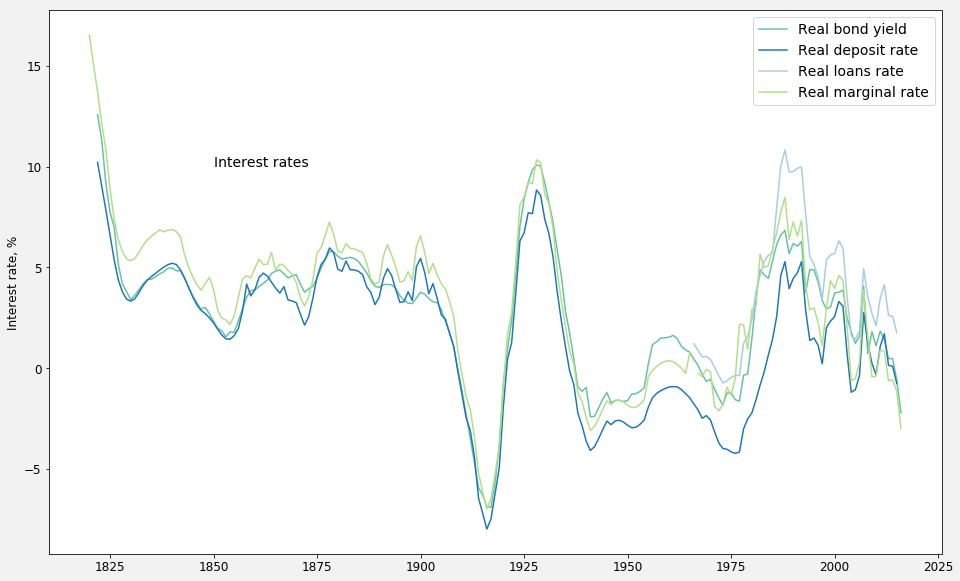

In [281]:
real_ir_long = pd.melt(real_ir, id_vars="Year")
fig, ax = plt.subplots()
for r in real_ir_long.groupby("variable"):
	ax.plot(r[1].Year, r[1].value, label=r[0])
ax.legend(fontsize=14)
ax.text(1850, 10, "Interest rates")
ax.set_ylabel("Interest rate, %")
fig.savefig("figures/ir_long.png")
plt.show()



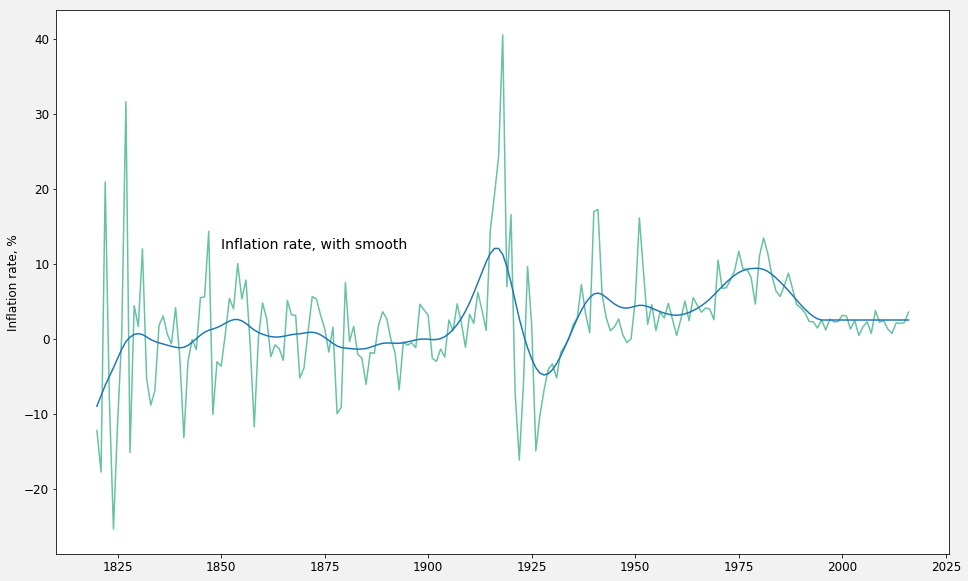

In [282]:
inflation_long = pd.melt(inflation, id_vars="Year")
fig, ax = plt.subplots()
for i in inflation_long.groupby("variable"):
	ax.plot(i[1].Year, i[1].value, label=i[0])
ax.text(1850, 12, "Inflation rate, with smooth")
ax.set_ylabel("Inflation rate, %")
# ax.legend()
#fig.savefig("figures/long_inflation_rate")
plt.show()

## Oil and Gas

#### brent oil price


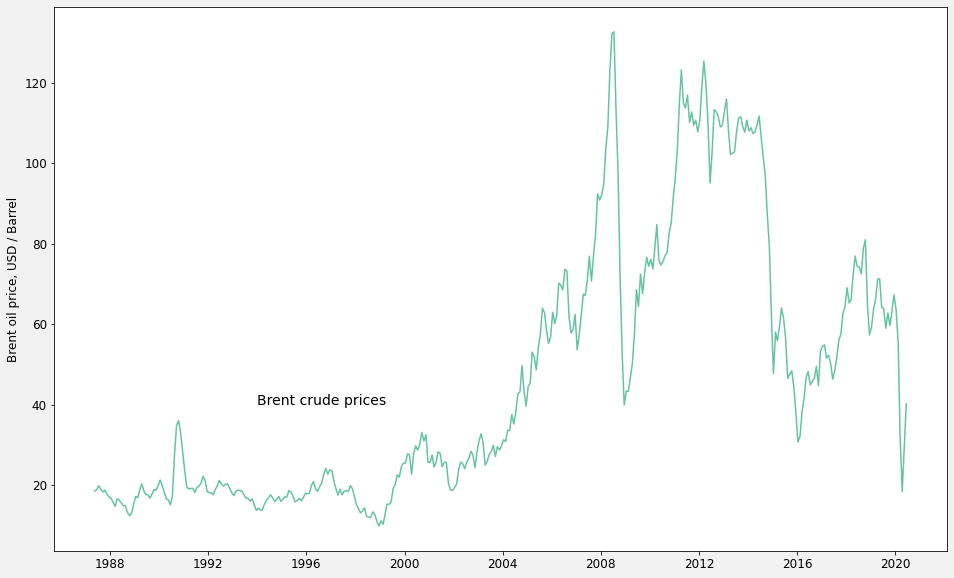

In [383]:
#prices from eia
xls = pd.ExcelFile("http://www.eia.gov/dnav/pet/hist_xls/RBRTEm.xls")
brent_prices = xls.parse('Data 1', header=2)

brent_prices.columns = ["date", "brent_price"]
brent_prices["date"] = pd.to_datetime(brent_prices.date, format="%Y-%m-%d")

brent_prices.to_csv("data_series/brent_prices.csv")

fig, ax = plt.subplots()
ax.plot(brent_prices.date, brent_prices.brent_price, label="Brent Crude Price, $/Barrel")
ax.text(yearmonth("199401"), 40, "Brent crude prices")
#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Brent oil price, USD / Barrel")
fig.savefig("figures/brent_prices.png")
plt.show()

In [384]:
#prices from NPD
tot_prod=pd.read_csv("http://factpages.npd.no/ReportServer?/FactPages/TableView/field_production_totalt_NCS_month__DisplayAllRows&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=158.37.94.56&CultureCode=nb-no")
tot_prod.columns = ['﻿prod_year', 'prod_month', 
'oil_millm3', 'gas_billsm3',
'ngl_millsm3', 'condensate_millsm3',
'oe_millsm3', 'water_millsm3']

tot_prod["date"] = pd.to_datetime(tot_prod.loc[:, '﻿prod_year'].astype(str) + tot_prod.loc[:,"prod_month"].astype(str),
	format = "%Y%m")

prod_include = ['date', 'oil_millm3', 'gas_billsm3','water_millsm3']
tot_prod = tot_prod[prod_include]

tot_prod_long = pd.melt(tot_prod, id_vars =["date"])
tot_prod_long["value"] = tot_prod_long.value.astype(float)
tot_prod_long = tot_prod_long[tot_prod_long.value!=0]

smoothed = tot_prod_long.groupby("variable")["value"].transform(smooth_series)
tot_prod_long["smoothed"] = smoothed


ParserError: Error tokenizing data. C error: Expected 1 fields in line 40, saw 4


In [385]:
tot_prod.head()

tot_prod.to_csv("data_series/petr_production.csv")

NameError: name 'tot_prod' is not defined

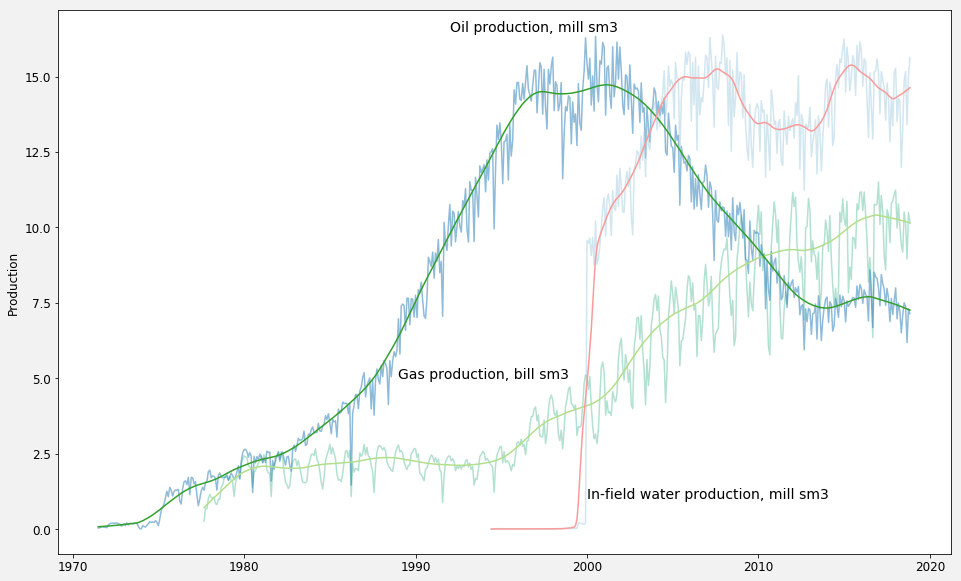

In [286]:
fig, ax = plt.subplots()
prod_by_liquid = tot_prod_long.groupby("variable")
for liquid in prod_by_liquid:
	ax.plot(liquid[1].date, liquid[1].value, label=liquid[0], alpha=.5)
for liquid in prod_by_liquid:
	ax.plot(liquid[1].date, liquid[1].smoothed)
#ax.legend()
ax.text(yearmonth("199201"), 16.5, "Oil production, mill sm3")
ax.text(yearmonth("198901"), 5, "Gas production, bill sm3")
ax.text(yearmonth("200001"), 1, "In-field water production, mill sm3")
ax.set_ylabel("Production")
fig.savefig("figures/oil_gas_production.png")
plt.show()

#### Investment in oil and gas fields

In [386]:
investments=pd.read_csv("http://factpages.npd.no/ReportServer?/FactPages/TableView/field_investment_yearly&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=158.37.94.112&CultureCode=en")

tot_investments = investments.groupby("prfYear")['prfInvestmentsMillNOK'].aggregate(sum)
tot_investments = tot_investments.reset_index()
tot_investments.columns = ["year", "invest_millNOK"]
tot_investments = tot_investments[tot_investments.invest_millNOK!=0]




ParserError: Error tokenizing data. C error: Expected 1 fields in line 40, saw 4


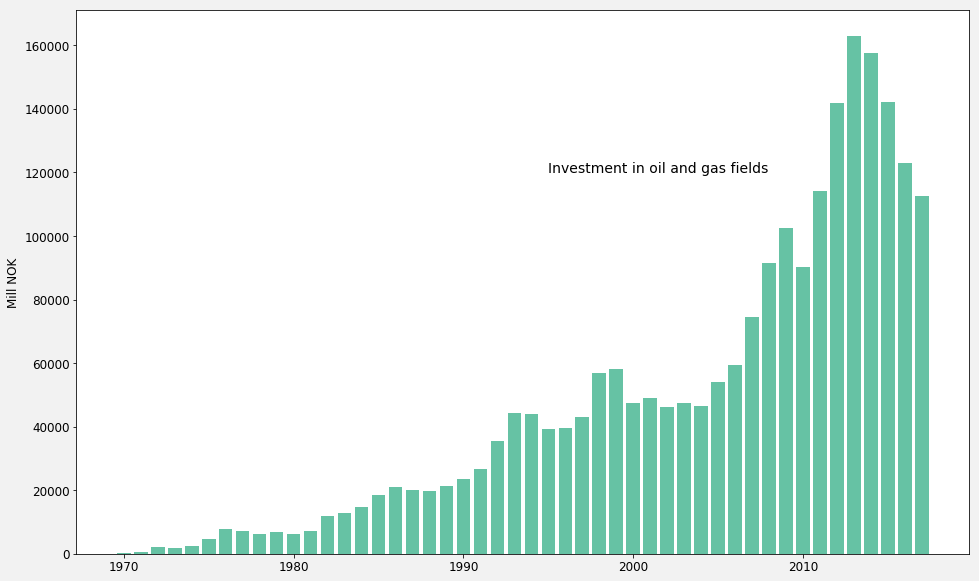

In [288]:
fig, ax = plt.subplots()
ax.bar(tot_investments.year, tot_investments.invest_millNOK, color="#66c2a4")
ax.set_ylabel("Mill NOK")
ax.text(1995, 120000, "Investment in oil and gas fields")
fig.savefig("figures/oil_investment.png", bbox_inches='tight')
plt.show()

# Wages and earnings

In [387]:
wages = pd.ExcelFile("http://www.norges-bank.no/WebDAV/hms/data/Wages_Ind.xlsx")
tot_wages = wages.parse('Table_total', header=2)
ind_wages = wages.parse('Table_6A4', header=3)

#total wages
tot_wages = tot_wages.iloc[:-12,:]
tot_wages["Year"][tot_wages.Year=="2014*"] = "2014"
tot_wages["Year"] = tot_wages.Year.astype(int)

tot_wages_long = pd.melt(tot_wages, id_vars="Year")



XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b'\r\n<!DOCT'

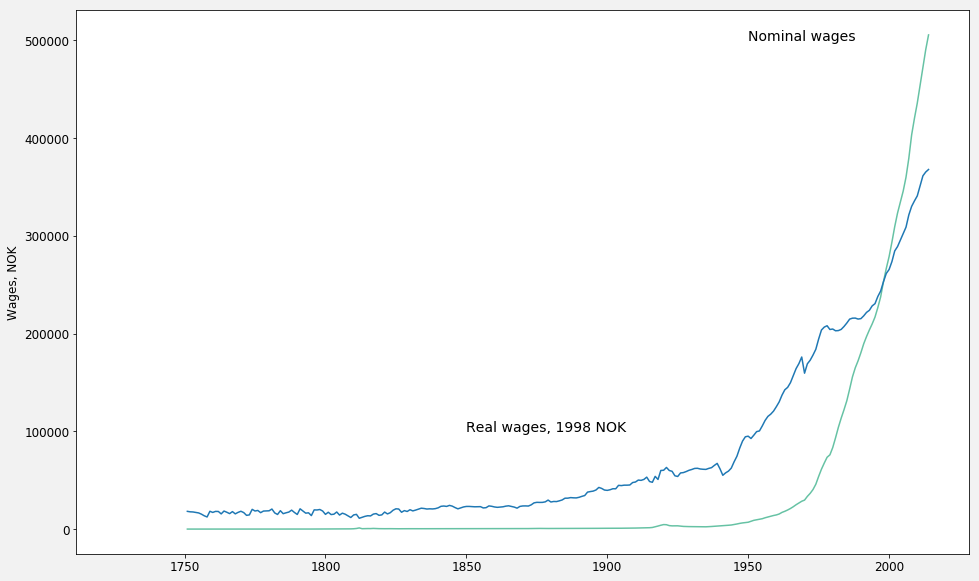

In [290]:
fig, ax = plt.subplots()
for wage in tot_wages_long.groupby("variable"):
	ax.plot(wage[1].Year, wage[1].value, label=wage[0])
ax.text(1850, 100000, "Real wages, 1998 NOK") 
ax.text(1950, 500000, "Nominal wages")
#ax.legend()
ax.set_ylabel("Wages, NOK")
fig.savefig("figures/tot_wages.png")
plt.show()

## Demographics

#### Population, by age grou

In [388]:
fm5aar=pd.read_csv("http://data.ssb.no/api/v0/dataset/65195.csv?lang=en", sep=",", encoding = "cp865")
fm5aar.head()

age           sex  year contents  \
0  F00-04 0-4 years  0 Both sexes  1846  Persons   
1  F00-04 0-4 years  0 Both sexes  1847  Persons   
2  F00-04 0-4 years  0 Both sexes  1848  Persons   
3  F00-04 0-4 years  0 Both sexes  1849  Persons   
4  F00-04 0-4 years  0 Both sexes  1850  Persons   

   10211: Population, by age, sex, year and contents  
0                                             170316  
1                                             171133  
2                                             170015  
3                                             170392  
4                                             176726

In [389]:
fm5aar.columns = ['alder', 'kjoenn', 'tid', 'statistikkvariabel',
       'personer']
fm5aar["alder"] = [i.split(" ")[1] for i in fm5aar.alder]


fm5aar.head()

alder        kjoenn   tid statistikkvariabel  personer
0   0-4  0 Both sexes  1846            Persons    170316
1   0-4  0 Both sexes  1847            Persons    171133
2   0-4  0 Both sexes  1848            Persons    170015
3   0-4  0 Both sexes  1849            Persons    170392
4   0-4  0 Both sexes  1850            Persons    176726

In [390]:
totalt = fm5aar[fm5aar.kjoenn == "0 Both sexes"]

totalt_fm5 = totalt[["tid", "alder", "personer"]]
totalt_fm5_w = totalt_fm5.pivot(index='tid', columns='alder', values='personer')
totalt_fm5_w.columns.values
totalt_fm5_w = totalt_fm5_w[['0-4','5-9', '10-14','15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49',  '50-54', '55-59', '60-64', '65-69',
       '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100']]

Y = np.array(totalt_fm5_w)

dates = totalt_fm5.tid.unique()



In [391]:
fm5_2015 = totalt_fm5[totalt_fm5.tid==2015]
fm5_2015["annotate_y"] = fm5_2015.personer.cumsum()
fm5_2015["annotate_y"] = [i-100000 for i in fm5_2015.annotate_y]
fm5_2015.head()

marks = ['0-4',  '10-14',  '20-24',  '30-34', 
       '40-44',  '50-54', '60-64','70-74',
        '80-84',  '100']

fm5_2015 = fm5_2015[fm5_2015.alder.isin(marks)]
fm5_2015["annotate_y"].iloc[-1] = fm5_2015["annotate_y"].iloc[-1] + 120000

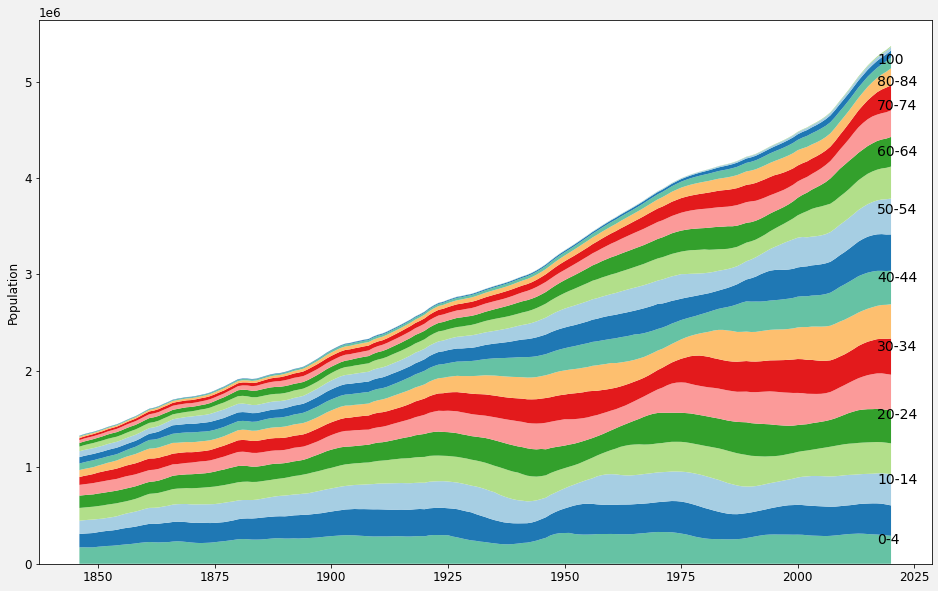

In [392]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for fm5 in fm5_2015.groupby("alder"):
    ax.annotate(fm5[0], xy=(2017, np.array(fm5[1].annotate_y)[0]))
ax.set_ylabel("Population")
fig.savefig("figures/pop_by_age.png")
plt.show()

#### Immigration

In [393]:
pop = pd.read_csv("http://data.ssb.no/api/v0/dataset/49626.csv?lang=no", sep=";")

pop.columns = ["region", "year", "variable", "value"]
pop = pop[["year", "variable", "value"]]
pop_tot = pop[pop.variable=="Folkemengde"]
pop_tot = pop_tot[["year", "value"]]
pop_tot.columns = ["year", "pop_tot"]

innvandring = pd.read_csv("http://data.ssb.no/api/v0/dataset/48651.csv?lang=no", sep=";")
innvandring.columns = ['region', 'kjoenn', 'landbakgrunn', 'year', 'statistikkvariabel',
       'innvandrer']
innvandring = innvandring[['kjoenn', 'landbakgrunn', 'year',
       'innvandrer']]
innvandring = innvandring.merge(pop_tot, on="year", how ="left")
innvandring["pros_innvan"] = innvandring["innvandrer"]/innvandring["pop_tot"]*100

total = innvandring.groupby(["year", "landbakgrunn"])["pros_innvan"].aggregate(sum)
total = total.reset_index()
total_w = total.pivot(index="year", columns="landbakgrunn", values="pros_innvan")
Y = np.array(total_w)
x=total.year.unique()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe5 in position 0: invalid continuation byte

In [ ]:
annotate_y = pd.DataFrame()
annotate_y["labels"] = ["Europe", "Africa", "Asia w Turkey", "North America", "South America", "Oseania"]
annotate_y["y"] = [6,8, 11, 12.5, 13, 13.5]

In [ ]:
for ant in annotate_y.iterrows():
    print(ant[1]["labels"])

NameError: name 'x' is not defined

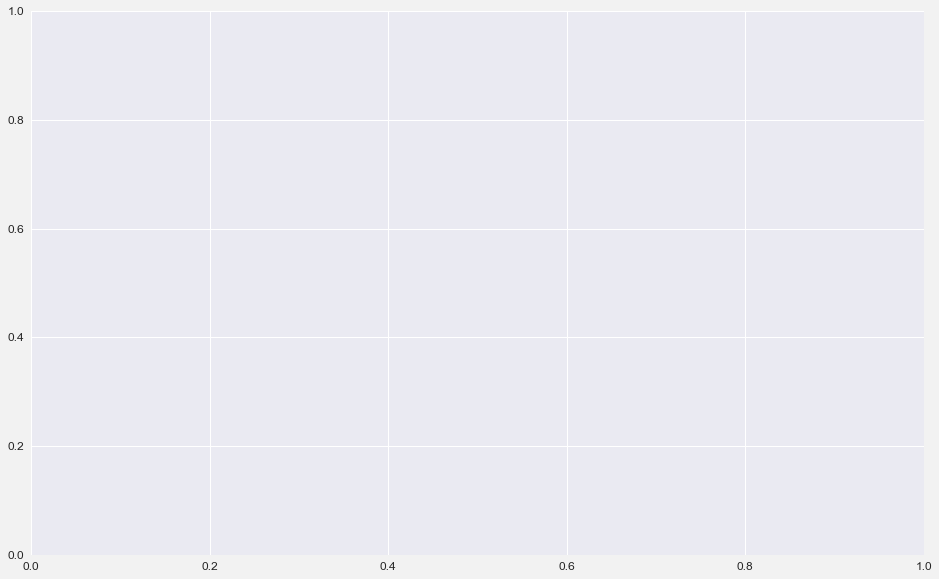

In [153]:

fig, ax = plt.subplots()
ax.stackplot(x, Y.T)
for ant in annotate_y.iterrows():
    ax.annotate(ant[1]["labels"], xy=(2017, ant[1]["y"]))
ax.set_ylabel("Immigrants as % of population, by origin")
fig.savefig("figures/imig_pros.png")
plt.show()

#### Migration to the cities

In [154]:
fylker = ['Oestfold', 'Akershus', 'Oslo', 'Hedmark', 'Oppland',
       'Buskerud', 'Vestfold', 'Telemark', 'Aust-Agder',
       'Vest-Agder', 'Rogaland', 'Hordaland',
       'Bergen', 'Sogn og Fjordane', 'Moere og Romsdal',
       'Sør-Trøndelag', 'Nord-Troendelag', 'Nordland',
       'Troms', 'Finnmark']


#Look at population
population = pd.read_csv("http://data.ssb.no/api/v0/dataset/49623.csv?lang=no", sep=";", encoding = "cp865")
population["tid"] = pd.to_datetime(population.tid, format="%Y")

population.region = population.region.astype('category')

population["region"] = population.region.cat.rename_categories(fylker)
population = population[population.region.isin(['Oslo', 'Rogaland', 'Hordaland','Sør-Trøndelag'])]

population.columns = ["region", "tid", "statistikkvariabel", "population"]
population["population"] = population.population.astype(float)
population.region = population.region.astype(str)

innflyttinger = population[population.statistikkvariabel.isin(["Innflyttinger"])]
del innflyttinger["statistikkvariabel"]
innflyttinger.columns = ['region', 'tid', 'innflyttinger']
innflyttinger["utflyttinger"] = population.population[population.statistikkvariabel=="Utflyttinger"].values
innflyttinger["net_migration"] = innflyttinger["innflyttinger"] - innflyttinger["utflyttinger"]
folkemengde = population[population.statistikkvariabel=="Folkemengde"]


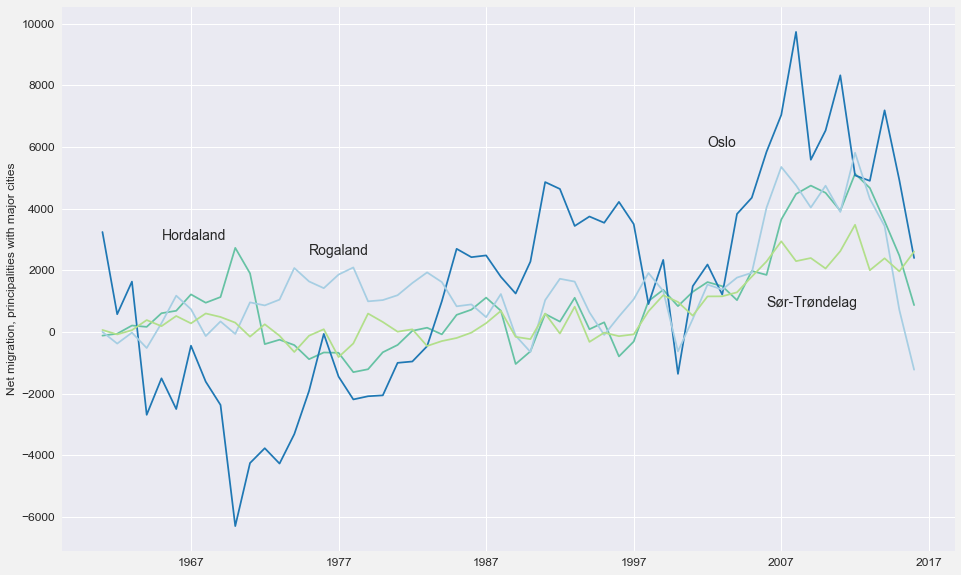

In [155]:

innflyttinger_by_city = innflyttinger.groupby("region")
fig, ax = plt.subplots()
for city in innflyttinger_by_city:
	ax.plot(city[1].tid.iloc[10:-1], city[1].net_migration.iloc[10:-1], label=city[0])
ax.text(pd.to_datetime(2002, format="%Y"), 6000, "Oslo")
ax.text(pd.to_datetime(1975, format="%Y"), 2500, "Rogaland")
ax.text(pd.to_datetime(2006, format="%Y"), 800, "Sør-Trøndelag")
ax.text(pd.to_datetime(1965, format="%Y"), 3000, "Hordaland")
ax.set_ylabel("Net migration, principalities with major cities")
fig.savefig("figures/net_migration_cities.png")
plt.show()



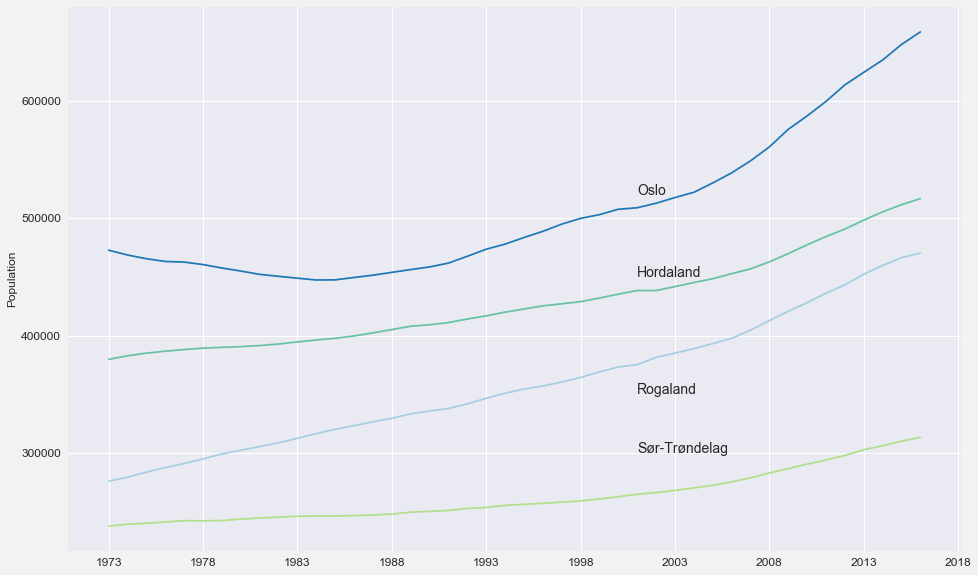

In [156]:
folkemengde_by_city = folkemengde.groupby("region")
fig, ax = plt.subplots()
for city in folkemengde_by_city:
	ax.plot(city[1].tid.iloc[22:-1], city[1].population.iloc[22:-1], label=city[0])
ax.text(pd.to_datetime(2001, format="%Y"), 520000, "Oslo")
ax.text(pd.to_datetime(2001, format="%Y"), 350000, "Rogaland")
ax.text(pd.to_datetime(2001, format="%Y"), 300000, "Sør-Trøndelag")
ax.text(pd.to_datetime(2001, format="%Y"), 450000, "Hordaland")
ax.set_ylabel("Population")
fig.savefig("figures/pop_cities.png")

plt.show()

In [157]:
folkemengde.head()

region        tid statistikkvariabel  population
670   Oslo 1951-01-01        Folkemengde    434365.0
675   Oslo 1952-01-01        Folkemengde    437184.0
680   Oslo 1953-01-01        Folkemengde    440674.0
685   Oslo 1954-01-01        Folkemengde    444041.0
690   Oslo 1955-01-01        Folkemengde    447064.0


#### Import and export

In [158]:
#laks_eksport = ("http://data.ssb.no/api/v0/dataset/1122?lang=no", sep=";")

## National Accounts

In [6]:
NR=pd.read_csv("http://data.ssb.no/api/v0/dataset/59022.csv", 
         sep=";", decimal=",", na_values = [".", ".."], encoding = "cp865")
NR.columns = ["variabel", "kvartal", "enhet", "verdi"]

NR["kvartal"]  = convert_datetime(NR.kvartal) #fra zoo

#sesong justert
NRSA = NR[NR.enhet == "Faste 2016-priser, sesongjustert (mill. kr)"]

#enhet "Faste 2013-priser, sesongjustert (mill. kr)"
NRSA = NRSA[["variabel", "kvartal", "verdi"]]

#use tidyr to split
kateg = NRSA.variabel.str.split('.', n=1).str[0]
variabel = NRSA.variabel.str.split(' ', n=1).str[1]

NRSA["kateg"] = kateg
NRSA["variabel"] = variabel


In [7]:
NRSA.head()

variabel    kvartal   verdi kateg
1  Konsum i husholdninger og ideelle organisasjoner 2000-03-01  216663   koh
3  Konsum i husholdninger og ideelle organisasjoner 2000-06-01  220303   koh
5  Konsum i husholdninger og ideelle organisasjoner 2000-09-01  220297   koh
7  Konsum i husholdninger og ideelle organisasjoner 2000-12-01  218974   koh
9  Konsum i husholdninger og ideelle organisasjoner 2001-03-01  221565   koh

In [8]:
#investering

investering = NRSA[NRSA.kateg =="bif"]
del investering["kateg"]

# invest_stack.reset_index(inplace=True)

# invest_stack = pd.melt(invest_stack, id_vars = "kvartal")

investering.head()
invest_w = investering.pivot(index='kvartal', columns='variabel', values='verdi')

invest_var = ['Total Investment', 'Fixed Assets',
       'Mainland Norway',
       'Foreign Shipping',
       'Extraction',
       'Mainland Norway, excl public sector',
       'Housing',
       'Private Sector',
       'Public Sector',
       'Other services',
       'Other production',
       'Industry and Mining',
       'Extraction Services']

invest_w.columns = invest_var

invest_stack = invest_w[["Extraction", "Housing", "Public Sector", "Total Investment"]]
invest_stack["Other"] = invest_stack["Total Investment"] - invest_stack[["Extraction", "Housing", "Public Sector"]].sum(axis=1)

del invest_stack["Total Investment"]


In [9]:
invest_stack.columns.values

array(['Extraction', 'Housing', 'Public Sector', 'Other'], dtype=object)

In [10]:
annotate = pd.DataFrame()
annotate["labels"] = ['Oil and Gas Extraction', 'Housing', 'Public Sector', 'Other']
annotate["Y"] = [10000, 50000, 80000, 120000]

Y = np.array(invest_stack)

dates = investering.kvartal.unique()


annotate

labels       Y
0  Oil and Gas Extraction   10000
1                 Housing   50000
2           Public Sector   80000
3                   Other  120000

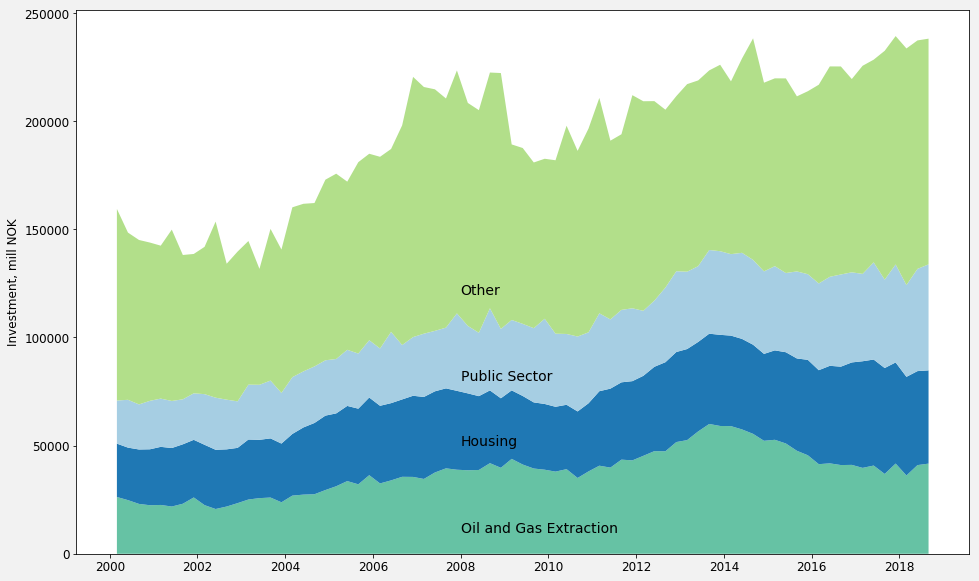

In [11]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
ax.set_ylabel("Investment, mill NOK")
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
fig.savefig("figures/na_investments.png")
plt.show()


### Eksport

In [12]:
eksport = NRSA[NRSA.kateg == "eks"]
del eksport["kateg"]
eksport_w = eksport.pivot(index='kvartal', columns='variabel', values='verdi')
eksport_w.columns =['Total', 'Oil and Gas',
       'Ships and Platforms', 'Services',
       'Traditional Commodities']
eksport_stack = eksport_w
del eksport_stack["Total"]


Y = np.array(eksport_stack)

dates = eksport_stack.index.values



In [13]:
annotate = pd.DataFrame()
annotate["labels"] = ['Oil and Gas', 'Ships and Platforms', 'Services', 'Other Commodities']
annotate["Y"] = [80000, 160000, 200000, 270000]


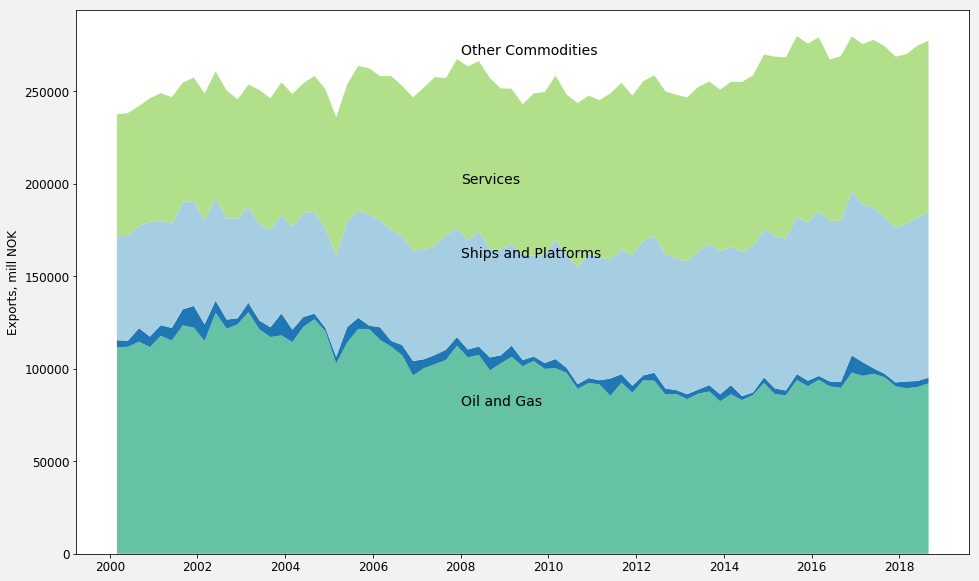

In [14]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Exports, mill NOK")
fig.savefig("figures/na_eksports.png")
plt.show()

### Imports 

In [40]:
imports =  NRSA[NRSA.kateg == "imp"]

del imports["kateg"]
imports_w = imports.pivot(index='kvartal', columns='variabel', values='verdi')

In [41]:

imports_w.columns =['Total', 'Oil and Gas',
       'Ships and Platforms', 'Services',
       'Other Goods']
       
imports_stack = imports_w
#del imports_stack["Total"]


Y = np.array(imports_stack)

dates = imports_stack.index.values

imports_w.head()

Total  Oil and Gas  Ships and Platforms  Services  Other Goods
kvartal                                                                    
2000-03-01  149994         1780                15944     53829        79239
2000-06-01  147712         1610                13937     53865        81219
2000-09-01  145130         2421                10421     52143        81413
2000-12-01  145170         2339                 6813     55219        81427
2001-03-01  149655         1992                 8039     57627        83246

In [42]:
imports_w.to_csv("data_series/import_qrtly.csv")

In [16]:
annotate = pd.DataFrame()
annotate["labels"] = ['Oil and Gas',
       'Ships and Platforms', 'Services',
       'Other Goods']
annotate["Y"] = [5000, 17000, 50000, 150000]


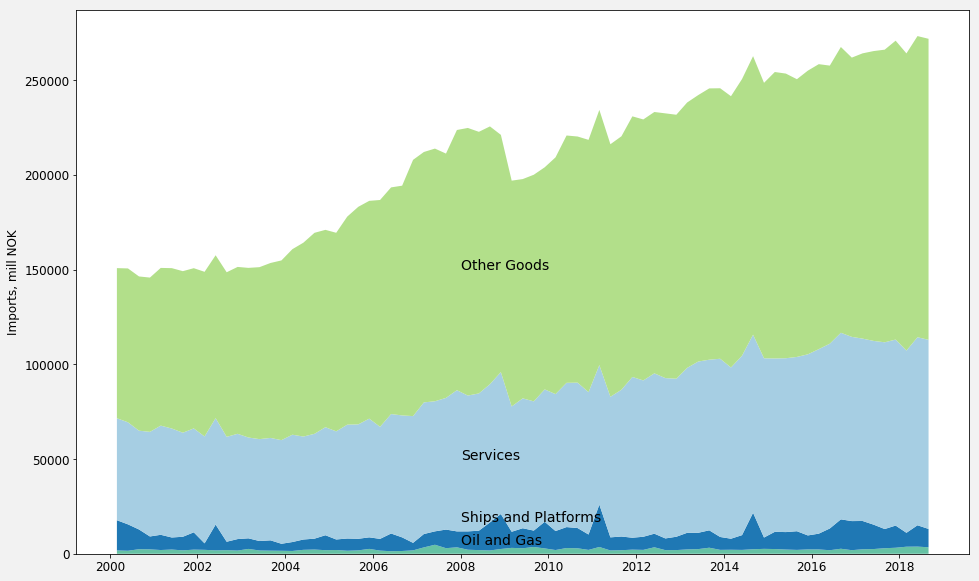

In [17]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Imports, mill NOK")
fig.savefig("figures/na_imports.png")
plt.show()

In [193]:
pkon = NRSA[NRSA.kateg=="koh"]

del pkon["kateg"]
pkon_w = pkon.pivot(index='kvartal', columns='variabel', values='verdi')
pkon_w.columns =['Household and Nonprofit',
       'Household', 'Household Foreign Consumption',
       'Services', 'Foreigners Consumption in Norway', 'Goods']

pkon_stack = pkon_w[['Services', 'Goods']]


Y = np.array(pkon_stack)

dates = pkon_stack.index.values



In [194]:
annotate = pd.DataFrame()
annotate["labels"] = ["Services", "Goods"]
annotate["Y"] = [50000, 150000]


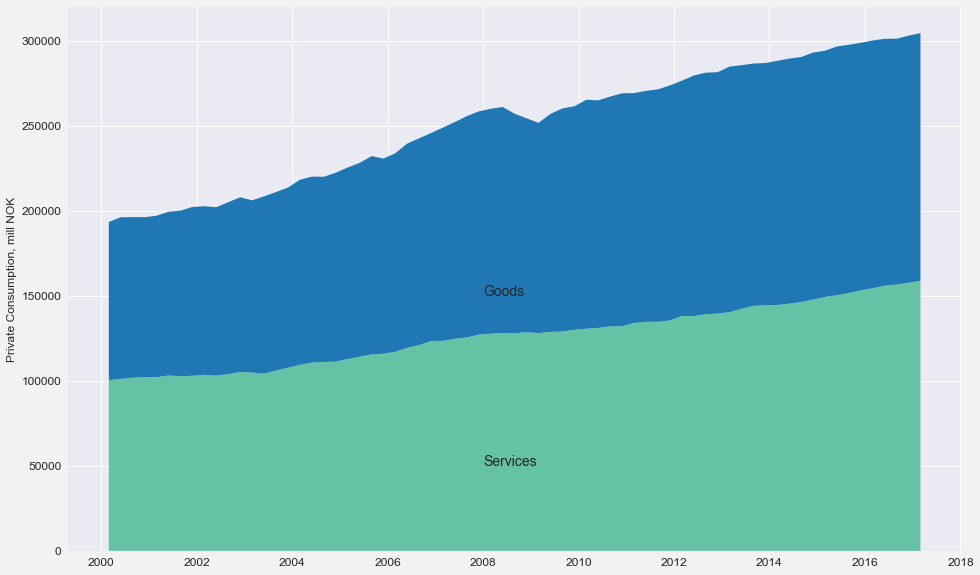

In [195]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Private Consumption, mill NOK")
fig.savefig("figures/na_privconsumption.png")
plt.show()

### Public sector 

In [27]:
okon = NRSA[NRSA.kateg=="koo"]

del okon["kateg"]
okon_w = okon.pivot(index='kvartal', columns='variabel', values='verdi')
okon_w.columns =['Public sector', 
	  'Principalities',
       'State',
       'State, Military',
       'State, Civil']

okon_stack = okon_w[['Principalities',
       'State, Military',
       'State, Civil']]

Y = np.array(okon_stack)

dates = okon_stack.index.values



In [28]:
annotate = pd.DataFrame()
annotate["labels"] = ['Principalities',
       'State, Military',
       'State, Civil']
annotate["Y"] = [40000, 90000, 120000]


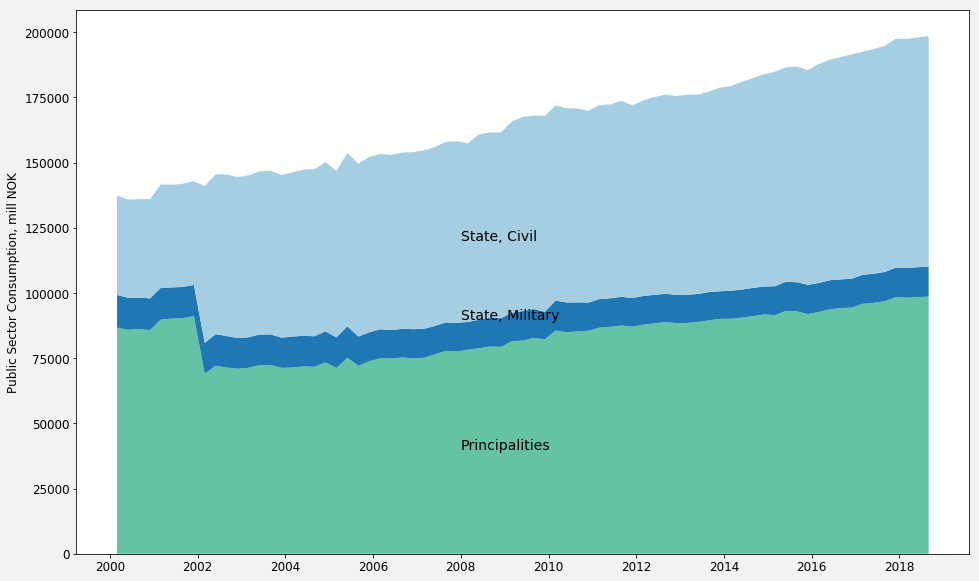

In [29]:
fig, ax = plt.subplots()
ax.stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax.annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax.set_ylabel("Public Sector Consumption, mill NOK")
fig.savefig("figures/na_publicconsumption.png")
plt.show()

### As share of GDP

In [30]:
bnp = NRSA[NRSA.kateg == "bnpb"]
bnp = bnp[bnp.variabel=='Bruttonasjonalprodukt, markedsverdi']
bnp = bnp[["kvartal", "verdi"]]
bnp.columns = ["kvartal", "bnp"]

bnp.to_csv("data_series/bnp.csv", index=False)

In [31]:
bnp.head()

kvartal     bnp
6151 2000-03-01  607318
6153 2000-06-01  598547
6155 2000-09-01  604356
6157 2000-12-01  604594
6159 2001-03-01  611667

In [32]:


okon_stack.reset_index(inplace=True)
okon_perc = okon_stack.merge(bnp, how="left", on="kvartal")
okon_perc["State, Military, %GDP"] = okon_perc["State, Military"]/okon_perc["bnp"]*100
okon_perc["State, Civil, %GDP"] = okon_perc["State, Civil"]/okon_perc["bnp"]*100
okon_perc["Principalities, %GDP"] = okon_perc["Principalities"]/okon_perc["bnp"]*100
okon_perc = okon_perc[['kvartal', 'State, Military, %GDP', 'Principalities, %GDP',
       'State, Civil, %GDP']]

okon_l = pd.melt(okon_perc,id_vars="kvartal")



In [33]:
annotate2 = pd.DataFrame()
annotate2["labels"] = ['State, Military',
       'State, Civil',
       'Principalities']
annotate2["Y"] = [2, 8, 11]


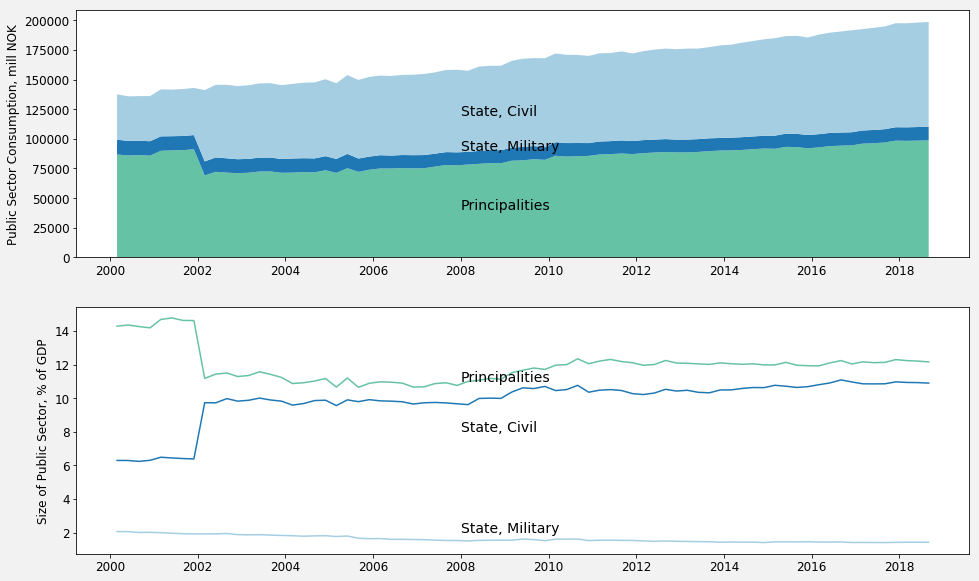

In [34]:
fig, ax = plt.subplots(2)
ax[0].stackplot(dates, Y.T)
for ant in annotate.iterrows():
    ax[0].annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
ax[0].set_ylabel("Public Sector Consumption, mill NOK")

start = datetime.strptime('01012008', '%d%m%Y')
okon_by_sector = okon_l.groupby("variable")
for sector in okon_by_sector:
	ax[1].plot(sector[1].kvartal, sector[1].value, label=sector[0])
ax[1].set_ylabel("Size of Public Sector, % of GDP")
for ant in annotate2.iterrows():
    ax[1].annotate(ant[1]["labels"], xy=(yearmonth("200801"), ant[1]["Y"]))
#fig.set_size_inches(12,15)
fig.savefig("figures/na_publicsector.png")
plt.show()

### Regionalt: Trondheim

#### house prices

In [35]:
trondheim_house_prices = total_cities.loc[total_cities.region == "Trondheim",]
trondheim_house_prices = trondheim_house_prices[["time", "value"]]
trondheim_house_prices.columns = ["date", "boligpriser"]

#percent change
trondheim_house_prices["perc_chang_priser"] = trondheim_house_prices.boligpriser.diff(periods=4)/trondheim_house_prices.boligpriser*100

trondheim_house_prices.head()


NameError: name 'total_cities' is not defined

NameError: name 'trondheim_house_prices' is not defined

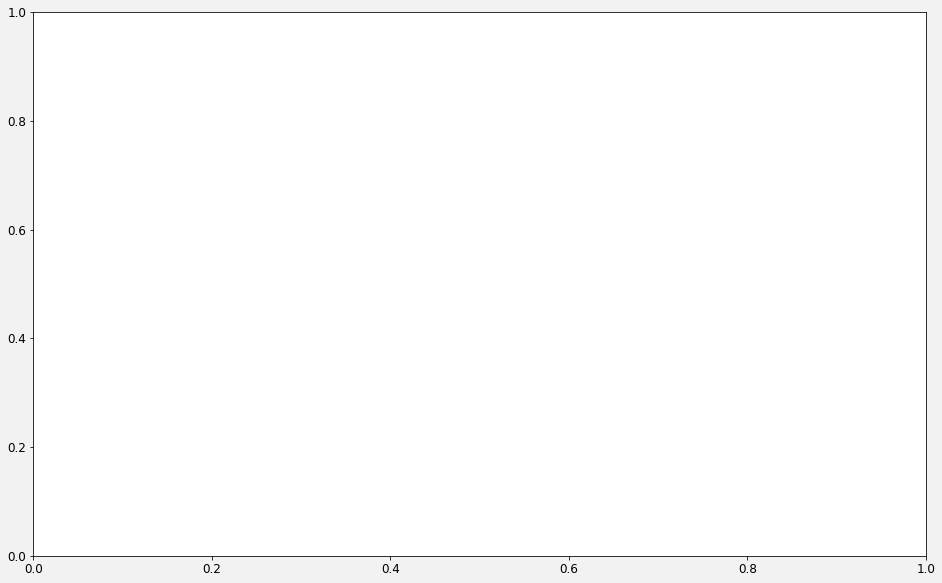

In [36]:
fig, ax = plt.subplots()
ax.plot(trondheim_house_prices.date, trondheim_house_prices.boligpriser)
plt.show()

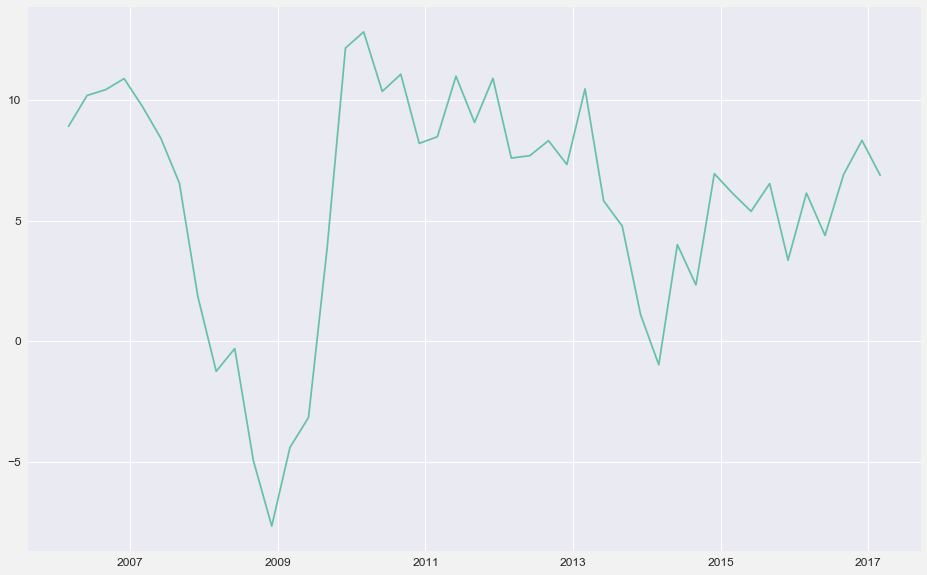

In [207]:
fig, ax = plt.subplots()
ax.plot(trondheim_house_prices.date, trondheim_house_prices.perc_chang_priser)
plt.show()

#### movement to trondheim

In [208]:
trond_innflytting = innflyttinger.loc[innflyttinger.region == "Sør-Trøndelag",]
trond_innflytting = trond_innflytting[["tid", "innflyttinger", "utflyttinger", "net_migration"]]
trond_innflytting.columns = ["date", "innflytting", "utflytting", "netto_migrasjon"]
trond_innflytting.head()

date  innflytting  utflytting  netto_migrasjon
5028 1951-01-01       8946.0      9592.0           -646.0
5033 1952-01-01       8117.0      8981.0           -864.0
5038 1953-01-01       8868.0      9422.0           -554.0
5043 1954-01-01       9067.0      9305.0           -238.0
5048 1955-01-01       9560.0     10130.0           -570.0

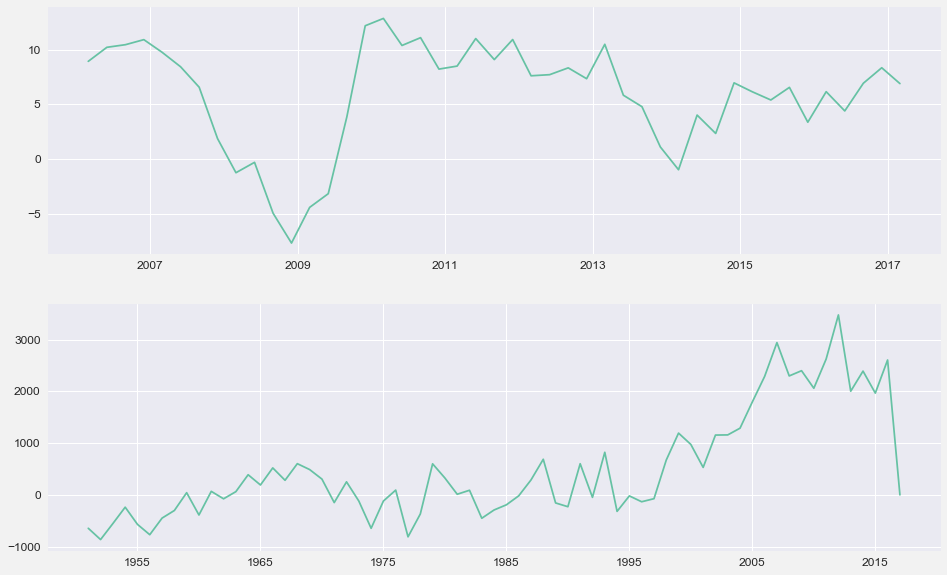

In [209]:
fig, ax = plt.subplots(2)
ax[0].plot(trondheim_house_prices.date, trondheim_house_prices.perc_chang_priser)
ax[1].plot(trond_innflytting.date, trond_innflytting.netto_migrasjon)
plt.show()

#### igangsatte

In [210]:
igangsatte.head()

region  statistikkvariabel        tid  boligbygging
0  0 Hele landet  Igangsatte boliger 1993-01-01        1072.0
1  0 Hele landet  Igangsatte boliger 1993-02-01         967.0
2  0 Hele landet  Igangsatte boliger 1993-03-01        1011.0
3  0 Hele landet  Igangsatte boliger 1993-04-01         915.0
4  0 Hele landet  Igangsatte boliger 1993-05-01        1093.0

In [214]:
bygging = pd.read_csv("http://data.ssb.no/api/v0/dataset/26025.csv?lang=no", sep=";", header=0, decimal=",", encoding = "cp865")
bygging["region"]=bygging.region.astype('category')

fylker = ['Oestfold', 'Akershus', 'Oslo', 'Hedmark', 'Oppland',
       'Buskerud', 'Vestfold', 'Telemark', 'Aust-Agder',
       'Vest-Agder', 'Rogaland', 'Hordaland', 'Sogn og Fjordane',
       'Moere og Romsdal', 'Soer-Troendelag', 'Nord-Troendelag',
       'Nordland', 'Troms', 'Finnmark',
       'Svalbard']

bygging["region"] = bygging.region.cat.rename_categories(fylker)

bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
bygging.statistikkvariabel.cat.categories
variabler = ['Boliger under arbeid', 'Fullfoert bruksareal (1 000 m2)',
       'Fullfoerte boliger', 'Igangsatt bruksareal (1 000 m2)',
       'Igangsatte boliger', 'Under arbeid, bruksareal (1 000 m�)']
bygging["statistikkvariabel"] = bygging.statistikkvariabel.cat.rename_categories(variabler)
bygging.rename(columns={"Boligbygg, etter region, statistikkvariabel og tid": "boligbygging"}, inplace=True)
bygging["tid"] = pd.to_datetime(bygging.tid, format="%YM%m")
bygging["boligbygging"]=bygging.boligbygging.astype(float)

In [215]:
bygging.region.unique()

[Oestfold, Akershus, Oslo, Hedmark, Oppland, ..., Nord-Troendelag, Nordland, Troms, Finnmark, Svalbard]
Length: 20
Categories (20, object): [Oestfold, Akershus, Oslo, Hedmark, ..., Nordland, Troms, Finnmark, Svalbard]

In [216]:
#bygging["statistikkvariabel"] = bygging.statistikkvariabel.astype("category")
trond_fullforte = bygging.loc[bygging.statistikkvariabel == "Fullfoerte boliger", ]
trond_fullforte.head()

region  statistikkvariabel        tid  boligbygging
1168  Oestfold  Fullfoerte boliger 1993-01-01         148.0
1169  Oestfold  Fullfoerte boliger 1993-02-01          42.0
1170  Oestfold  Fullfoerte boliger 1993-03-01          26.0
1171  Oestfold  Fullfoerte boliger 1993-04-01          29.0
1172  Oestfold  Fullfoerte boliger 1993-05-01          39.0

In [217]:

trond_fullforte = trond_fullforte.loc[trond_fullforte.region == "Soer-Troendelag", ]
trond_fullforte = trond_fullforte[["tid", "boligbygging"]]
trond_fullforte.columns = ["date", "fullforte_bolig"]
trond_fullforte.head()


date  fullforte_bolig
25696 1993-01-01             84.0
25697 1993-02-01             54.0
25698 1993-03-01             89.0
25699 1993-04-01             57.0
25700 1993-05-01             55.0

In [218]:

t = len(trond_fullforte.date)
T = [i for i in range(t)]

s_fullforte = UnivariateSpline(T, trond_fullforte.fullforte_bolig, k=3, s=2000000)
smooth_fullforte = s_fullforte(T)

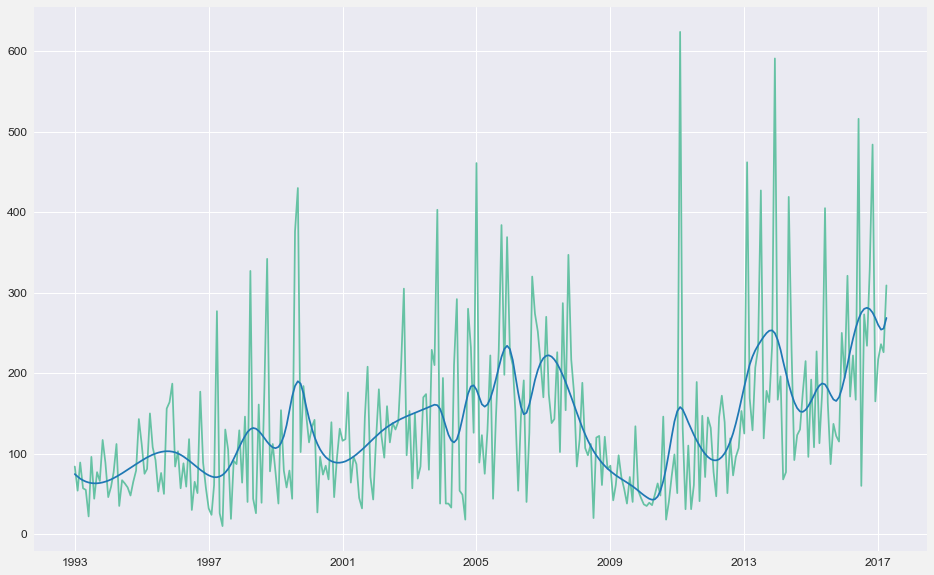

In [219]:
fig, ax = plt.subplots()
ax.plot(trond_fullforte.date, trond_fullforte.fullforte_bolig)
ax.plot(trond_fullforte.date, smooth_fullforte)
plt.show()

In [220]:
smooth_data.head()

date       Oslo   Hordaland    Rogaland  Soer-Troendelag
3504 1993-01-01 -18.215382  129.967503   86.939034        46.225609
3505 1993-02-01   9.368438  125.672868  104.479728        48.680539
3506 1993-03-01  34.497111  123.124961  120.414966        51.150916
3507 1993-04-01  57.263867  122.163363  134.808047        53.637779
3508 1993-05-01  77.761934  122.627658  147.722272        56.142168

In [221]:
trondelag_smooth = smooth_data[["date", "Soer-Troendelag"]]
trondelag_smooth.columns = ["date", "igangsatte"]
trondelag_smooth.head()

date  igangsatte
3504 1993-01-01   46.225609
3505 1993-02-01   48.680539
3506 1993-03-01   51.150916
3507 1993-04-01   53.637779
3508 1993-05-01   56.142168

In [222]:
ingangsatte_trondelag = Soer_Troendelag
ingangsatte_trondelag.head()

region  statistikkvariabel        tid  boligbygging
24528  Soer-Troendelag  Igangsatte boliger 1993-01-01          36.0
24529  Soer-Troendelag  Igangsatte boliger 1993-02-01          58.0
24530  Soer-Troendelag  Igangsatte boliger 1993-03-01          43.0
24531  Soer-Troendelag  Igangsatte boliger 1993-04-01          31.0
24532  Soer-Troendelag  Igangsatte boliger 1993-05-01          95.0

In [223]:
ingangsatte_trondelag.tid.max()

Timestamp('2017-04-01 00:00:00')

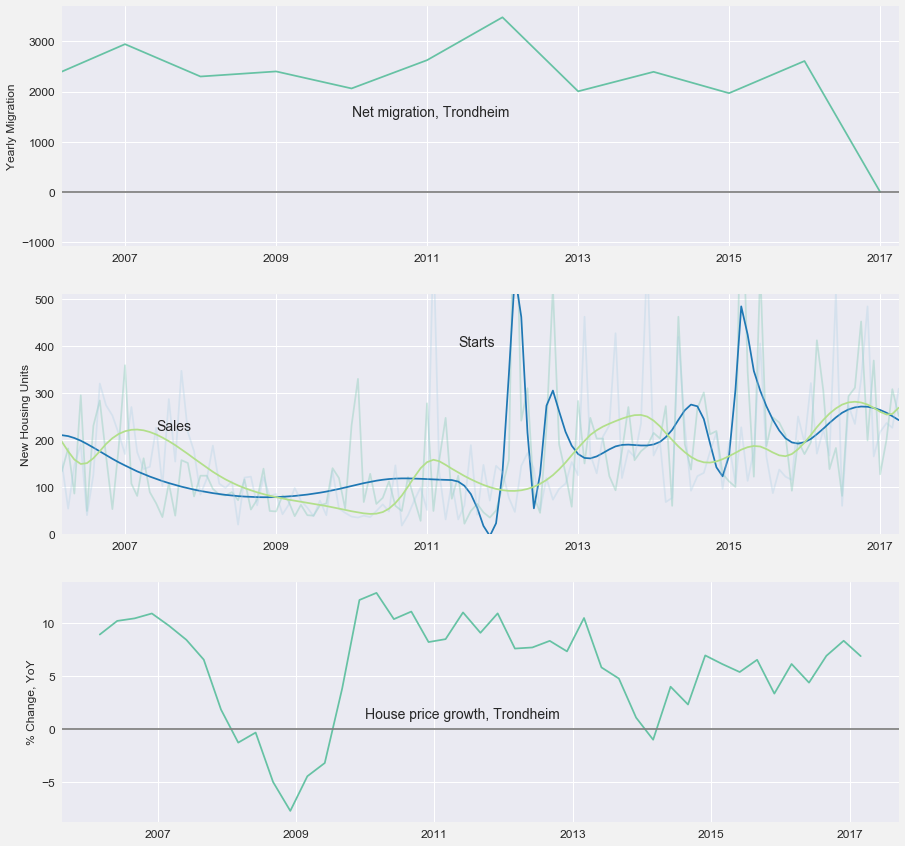

In [224]:
fig, ax = plt.subplots(3)
ax[0].plot(trond_innflytting.date, trond_innflytting.netto_migrasjon)
ax[0].set_xlim(pd.to_datetime("2006-03-01"), ingangsatte_trondelag.tid.max())
ax[0].axhline(color="grey")
ax[0].set_ylabel("Yearly Migration")
ax[0].text(yearmonth("201001"), 1500, "Net migration, Trondheim")
ax[1].plot(ingangsatte_trondelag.tid, 
           ingangsatte_trondelag.boligbygging, alpha=.3)
ax[1].plot(trondelag_smooth.date, 
           trondelag_smooth.igangsatte)
ax[1].plot(trond_fullforte.date, trond_fullforte.fullforte_bolig, alpha=.3)
ax[1].plot(trond_fullforte.date, smooth_fullforte)
ax[1].set_xlim(pd.to_datetime("2006-03-01"), ingangsatte_trondelag.tid.max())
ax[1].set_ylim(0, 510)
ax[1].set_ylabel("New Housing Units")
ax[1].text(yearmonth("201106"), 400, "Starts")
ax[1].text(yearmonth("200706"), 220, "Sales")

ax[2].plot(trondheim_house_prices.date, trondheim_house_prices.perc_chang_priser)
ax[2].set_ylabel("% Change, YoY")
ax[2].text(yearmonth("201001"), 1, "House price growth, Trondheim")
ax[2].axhline(color="grey")
fig.set_size_inches(15,15)
fig.savefig("figures/trondheim_housing_market.png")
plt.show()